In [1]:
from astroquery.mast import Catalogs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
from scipy.stats import mode
from astroquery.sdss import SDSS
from astropy.coordinates import SkyCoord
import astropy.units as u
from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
from astropy.io.votable import parse
from matplotlib.patches import Rectangle
from astroquery.mast import Catalogs
from scipy.integrate import simps 
import speclite.filters
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.stats import zscore
from scipy.stats import median_abs_deviation

In [2]:

def ra_to_degrees(ra):
    """""
    converting right ascension in 'HHMMSS.ss' format into degrees
    """""
    hours = int(ra[:2])  
    minutes = int(ra[2:4]) 
    seconds = float(ra[4:]) 
    ra_deg = (hours + minutes / 60 + seconds / 3600) * 15
    return ra_deg

def dec_to_degrees(dec):
    """""
    Converting declination in 'DDMMSS.s' format into degrees
    """""
    sign = -1 if dec[0] == '-' else 1
    degrees = int(dec[1:3])  
    minutes = int(dec[3:5])  
    seconds = float(dec[5:])  
    dec_degrees = sign * (degrees + minutes / 60 + seconds / 3600)
    return dec_degrees


file = '/Users/amberbarlow/Downloads/dc_sample_ids.csv' 
df = pd.read_csv(file)

df[['RA', 'Dec']] = df['sdssj_name_green'].str.extract(r'([+-]?\d*\.?\d+)([+-]\d+\.?\d+)')
df['RA_degrees'] = df['RA'].apply(ra_to_degrees)
df['Dec_degrees'] = df['Dec'].apply(dec_to_degrees)
df = df.drop(columns=['sdssj_name_green', 'RA', 'Dec'])
df = df.drop(columns=['gaia_source_id'])

csv_output_file = '/Users/amberbarlow/Downloads/963coordinates.csv'  
df.to_csv(csv_output_file, index=False)

astropy_table = Table.from_pandas(df)
hdu = fits.BinTableHDU(astropy_table)

fits_file = '/Users/amberbarlow/Downloads/963data.fits' 
hdu.writeto(fits_file, overwrite=True)


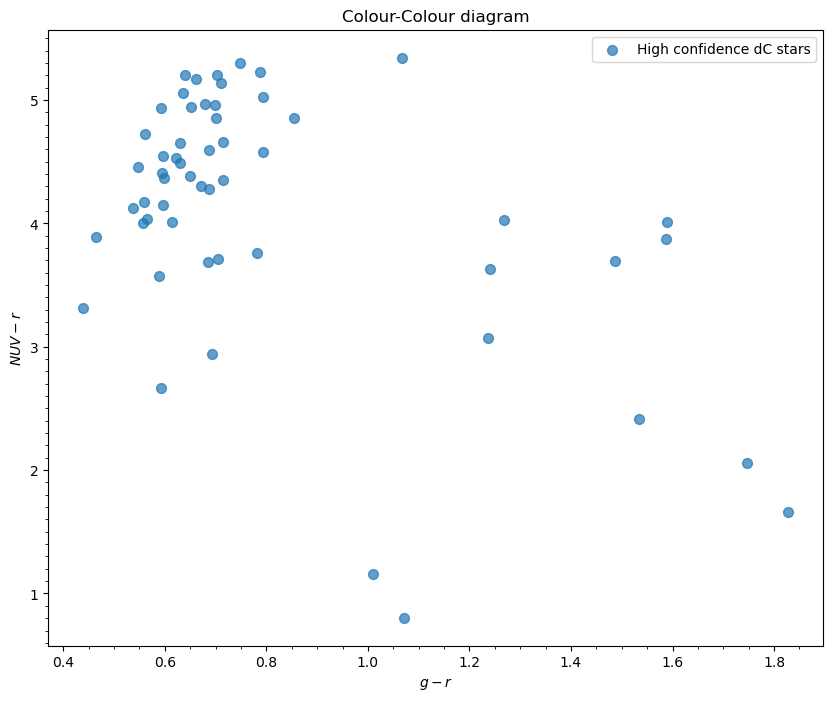

In [3]:
# loading the galex data
galex_file_path = '/Users/amberbarlow/Downloads/galexcorrect.fits'
galex_table = Table.read(galex_file_path)
galex_df = galex_table.to_pandas()
sdss_file_path = '/Users/amberbarlow/Downloads/coordinates.fits'
sdss_table = Table.read(sdss_file_path)
sdss_df = sdss_table.to_pandas()
merged_data = pd.merge(sdss_df, galex_df, on=['RA_degrees', 'Dec_degrees'],  how='inner')


# Calculating color indices
merged_data['NUV-r'] = merged_data['NUVmag'] - merged_data['rpmag']
merged_data['g-r'] = merged_data['gpmag'] - merged_data['rpmag']
merged_data['r-i'] = merged_data['rpmag'] - merged_data['ipmag']

merged_data = merged_data.dropna(subset=['NUV-r', 'g-r', 'r-i'])

#plotting the data
plt.figure(figsize=(10, 8), dpi=100)
plt.scatter(merged_data['g-r'], merged_data['NUV-r'], s=50, alpha=0.7, label='High confidence dC stars')
plt.xlabel('$g - r$')
plt.ylabel('$NUV - r$')
plt.title('Colour-Colour diagram')
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.05))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
plt.legend()
plt.show()

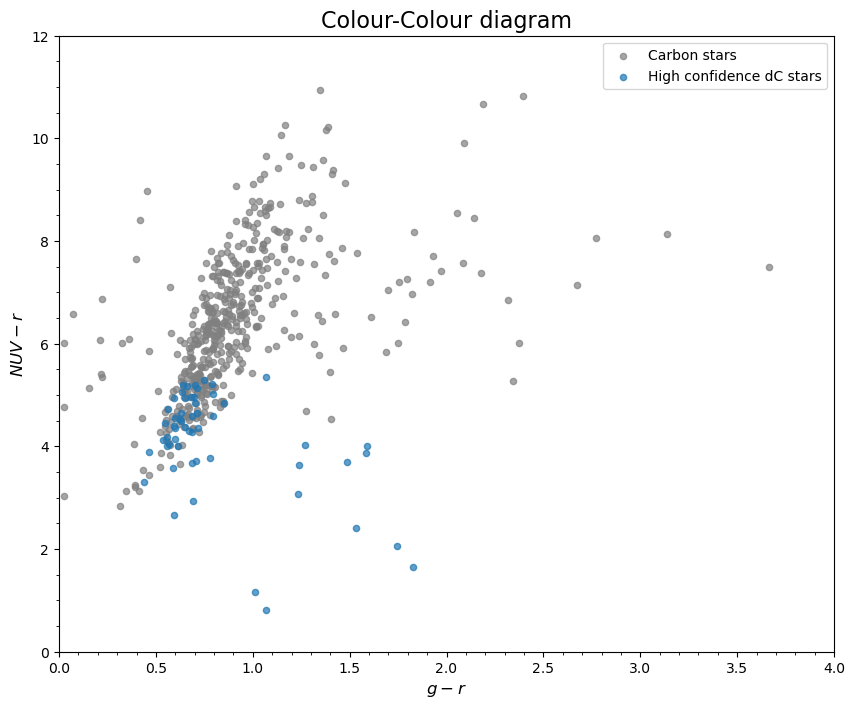

In [4]:
galex_file = '/Users/amberbarlow/Downloads/nuvmag.fits'
galex_table = Table.read(galex_file)
galex_df = galex_table.to_pandas()


galex_df['NUV-r'] = galex_df['NUVmag'] - galex_df['rpmag']
galex_df['g-r'] = galex_df['gpmag'] - galex_df['rpmag']


plt.figure(figsize=(10, 8))
#plt.scatter(sun_df['g-r'], sun_df['NUV-r'], s=300, marker='*', alpha=0.7, label='The sun', color='red')
plt.scatter(galex_df['g-r'], galex_df['NUV-r'], s=20, alpha=0.7, label='Carbon stars', color='grey')
plt.scatter(merged_data['g-r'], merged_data['NUV-r'], s=20, alpha=0.7, label='High confidence dC stars')
plt.xlabel('$g - r$', fontsize=12)
plt.ylabel('$NUV - r$', fontsize=12)
plt.title('Colour-Colour diagram', fontsize=16)
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))  
plt.legend()
plt.xlim(0, 4)
plt.ylim(0, 12)
plt.show()


# [Fe/H] = -1

In [5]:
# [FE/H]= -1
sdss_file = '/Users/amberbarlow/Downloads/feh_m1.00_SDSS.iso.cmd'
sdss_columns = [
    "age", "inital_mass", "star_mass", "log_teff",
    "log_g", "log_l", "[FE/H]_init", "[FE/H]", "sdss_u", "sdss_g", "sdss_r", "sdss_i", "sdss_z", "phase"]

df_sdss = pd.read_csv(
    sdss_file,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=sdss_columns
)

# [FE/H]= -1
galex_file = '/Users/amberbarlow/Downloads/feh_m1.00_GALEX.iso.cmd'

galex_columns = [
    "age", "inital_mass", "star_mass", "log_teff",
    "log_g", "log_l", "[FE/H]_init", "[FE/H]", "GALEX_FUV", "GALEX_NUV", "phase"]

df_galex = pd.read_csv(
    galex_file,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=galex_columns
)

merged_df = pd.merge_asof(
    df_sdss,
    df_galex,
    on='age',               
    direction='nearest',    
    tolerance=1e-4,       
    suffixes=('_sdss', '_galex')
)


avg_age =  np.log10(10e9) 
min_logg = 2.5
df_restricted = merged_df[
    (merged_df['age'] == avg_age) &
    (merged_df['log_g_sdss'] >= min_logg) &
    (merged_df['log_g_galex'] >= min_logg)
]



df_restricted['NUV-r'] = df_restricted['GALEX_NUV'] - df_restricted['sdss_r']
df_restricted['r-i'] = df_restricted['sdss_r'] - df_restricted['sdss_i']
df_restricted['g-r'] = df_restricted['sdss_g'] - df_restricted['sdss_r']

/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/3309274002.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted['NUV-r'] = df_restricted['GALEX_NUV'] - df_restricted['sdss_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/3309274002.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted['r-i'] = df_restricted['sdss_r'] - df_restricted['sdss_i']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/3309274002.py:52: SettingWithCopyWarni

# [Fe/H] = 0

In [6]:
# [FE/H]= 0
galex_file2 = '/Users/amberbarlow/Downloads/feh_p0.00_GALEX.iso.cmd'


galex_columns2 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "GALEX_FUV", "GALEX_NUV", "phase"
] 

df_galex2 = pd.read_csv(
    galex_file2,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=galex_columns2
)

sdss_file2 = '/Users/amberbarlow/Downloads/feh_p0.00_SDSSugriz.iso.cmd'

sdss_columns2 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "SDSS_u", "SDSS_g", "SDSS_r", "SDSS_i", "SDSS_z", "phase"
] 

df_sdss2 = pd.read_csv(
    sdss_file2,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=sdss_columns2
)

merged_df2 = pd.merge_asof(
    df_sdss2,
    df_galex2,
    on='age',                
    direction='nearest',    
    tolerance=1e-4,       
    suffixes=('_sdss', '_galex')
)


avg_age =  np.log10(10e9) 
df_restricted2 = merged_df2[
    (merged_df2['age'] == avg_age) &
    (merged_df2['log_g_sdss'] >= min_logg) &
    (merged_df2['log_g_galex'] >= min_logg)
]

df_restricted2['NUV-r'] = df_restricted2['GALEX_NUV'] - df_restricted2['SDSS_r']
df_restricted2['g-r'] = df_restricted2['SDSS_g'] - df_restricted2['SDSS_r']
df_restricted2['r-i'] = df_restricted2['SDSS_r'] - df_restricted2['SDSS_i']


/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/4213168371.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted2['NUV-r'] = df_restricted2['GALEX_NUV'] - df_restricted2['SDSS_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/4213168371.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted2['g-r'] = df_restricted2['SDSS_g'] - df_restricted2['SDSS_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/4213168371.py:52: SettingWithCop

# [Fe/H] = -1.5

In [7]:
galex_file3 = '/Users/amberbarlow/Downloads/m1.50_GALEX.iso.cmd'

galex_columns3 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "GALEX_FUV", "GALEX_NUV", "phase"
] 

df_galex3 = pd.read_csv(
    galex_file3,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=galex_columns3
)



sdss_file3 = '/Users/amberbarlow/Downloads/MIST_v1.2_feh_m1.50_afe_p0.0_vvcrit0.4_SDSSugriz.iso.cmd'

sdss_columns3 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "SDSS_u", "SDSS_g", "SDSS_r", "SDSS_i", "SDSS_z", "phase"
] 

df_sdss3 = pd.read_csv(
    sdss_file3,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=sdss_columns3
)

merged_df3 = pd.merge_asof(
    df_sdss3,
    df_galex3,
    on='age',                
    direction='nearest',    
    tolerance=1e-4,       
    suffixes=('_sdss', '_galex')
)

avg_age =  np.log10(10e9) 
df_restricted3 = merged_df3[
    (merged_df3['age'] == avg_age) &
    (merged_df3['log_g_sdss'] >= min_logg) &
    (merged_df3['log_g_galex'] >= min_logg)
]
    

df_restricted3['NUV-r'] = df_restricted3['GALEX_NUV'] - df_restricted3['SDSS_r']
df_restricted3['r-i'] = df_restricted3['SDSS_r'] - df_restricted3['SDSS_i']
df_restricted3['g-r'] = df_restricted3['SDSS_g'] - df_restricted3['SDSS_r']

/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/3541757477.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted3['NUV-r'] = df_restricted3['GALEX_NUV'] - df_restricted3['SDSS_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/3541757477.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted3['r-i'] = df_restricted3['SDSS_r'] - df_restricted3['SDSS_i']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/3541757477.py:52: SettingWithCop

# [Fe/H] = 0.5

In [8]:
galex_file4 = '/Users/amberbarlow/Downloads/m0.50_GALEX.iso.cmd'

galex_columns4 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "GALEX_FUV", "GALEX_NUV", "phase"
] 

df_galex4 = pd.read_csv(
    galex_file4,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=galex_columns4
)



sdss_file4 = '/Users/amberbarlow/Downloads/m0.50_SDSSugriz.iso.cmd'

sdss_columns4 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "SDSS_u", "SDSS_g", "SDSS_r", "SDSS_i", "SDSS_z", "phase"
] 

df_sdss4 = pd.read_csv(
    sdss_file4,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=sdss_columns4
)

merged_df4 = pd.merge_asof(
    df_sdss4,
    df_galex4,
    on='age',                
    direction='nearest',    
    tolerance=1e-4,       
    suffixes=('_sdss', '_galex')
)

avg_age =  np.log10(10e9) 
min_logg = 3.5
df_restricted4 = merged_df4[
    (merged_df4['age'] == avg_age) &
    (merged_df4['log_g_sdss'] >= min_logg) &
    (merged_df4['log_g_galex'] >= min_logg)
]


df_restricted4['NUV-r'] = df_restricted4['GALEX_NUV'] - df_restricted4['SDSS_r']
df_restricted4['r-i'] = df_restricted4['SDSS_r'] - df_restricted4['SDSS_i']
df_restricted4['g-r'] = df_restricted4['SDSS_g'] - df_restricted4['SDSS_r']

/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/854942553.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted4['NUV-r'] = df_restricted4['GALEX_NUV'] - df_restricted4['SDSS_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/854942553.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted4['r-i'] = df_restricted4['SDSS_r'] - df_restricted4['SDSS_i']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/854942553.py:53: SettingWithCopyWa

#  [FE/H]= -2

In [9]:
galex_file5 = '/Users/amberbarlow/Downloads/m2.00.iso.cmd'

galex_columns5 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "GALEX_FUV", "GALEX_NUV", "phase"
] 

df_galex5 = pd.read_csv(
    galex_file3,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=galex_columns5
)



sdss_file5 = '/Users/amberbarlow/Downloads/m2.iso.cmd'

sdss_columns5 = [
    "age", "EEP", "inital_mass", "star_mass", "log_g", "log_Teff", "log_L", "[FE/H]_init",
    "SDSS_u", "SDSS_g", "SDSS_r", "SDSS_i", "SDSS_z", "phase"
] 

df_sdss5 = pd.read_csv(
    sdss_file5,
    delim_whitespace=True,
    comment='#',
    header=None,
    names=sdss_columns5
)

merged_df5 = pd.merge_asof(
    df_sdss5,
    df_galex5,
    on='age',                
    direction='nearest',    
    tolerance=1e-4,       
    suffixes=('_sdss', '_galex')
)


avg_age =  np.log10(10e9) 
df_restricted5 = merged_df5[
    (merged_df5['age'] == avg_age) &
    (merged_df5['log_g_sdss'] >= min_logg) &
    (merged_df5['log_g_galex'] >= min_logg)
]



df_restricted5['NUV-r'] = df_restricted5['GALEX_NUV'] - df_restricted5['SDSS_r']
df_restricted5['r-i'] = df_restricted5['SDSS_r'] - df_restricted5['SDSS_i']
df_restricted5['g-r'] = df_restricted5['SDSS_g'] - df_restricted5['SDSS_r']

/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/2175649105.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted5['NUV-r'] = df_restricted5['GALEX_NUV'] - df_restricted5['SDSS_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/2175649105.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted5['r-i'] = df_restricted5['SDSS_r'] - df_restricted5['SDSS_i']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/2175649105.py:54: SettingWithCop

In [10]:
#SDSS J084259.79+225729.8
system = merged_data[merged_data["objID"] == 1237673809196089561]
system['NUV-r'] = system['NUVmag'] - system['rpmag']
system['g-r'] = system['gpmag'] - system['rpmag']

#SDSS J020738.05+211913.3
system2 = merged_data[(merged_data["RA_degrees"] == 31.90854166666667) & (merged_data["Dec_degrees"] == 21.32036111111111)]
system2['NUV-r'] = system2['NUVmag'] - system2['rpmag']
system2['g-r'] = system2['gpmag'] - system2['rpmag']

#SDSS J012321.06-004549.8
system4 = merged_data[(merged_data["RA_degrees"] == 113.42195833333332) & (merged_data["Dec_degrees"] == 22.46636111111111)]
system4['NUV-r'] = system4['NUVmag'] - system4['rpmag']
system4['g-r'] = system4['gpmag'] - system4['rpmag']

#SDSS J073341.26+222758.7
system3 = merged_data[(merged_data["RA_degrees"] == 20.837791666666664) & (merged_data["Dec_degrees"] == -0.7638611111111111)]
system3['NUV-r'] = system3['NUVmag'] - system3['rpmag']
system3['g-r'] = system3['gpmag'] - system3['rpmag']

#SDSS J134346.21+463424.4
system5 = merged_data[(merged_data["RA_degrees"] == 205.94254166666667) & (merged_data["Dec_degrees"] == 46.57344444444445)]
system5['NUV-r'] = system5['NUVmag'] - system5['rpmag']
system5['g-r'] = system5['gpmag'] - system5['rpmag']

/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/2297449863.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system['NUV-r'] = system['NUVmag'] - system['rpmag']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/2297449863.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  system['g-r'] = system['gpmag'] - system['rpmag']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/2297449863.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

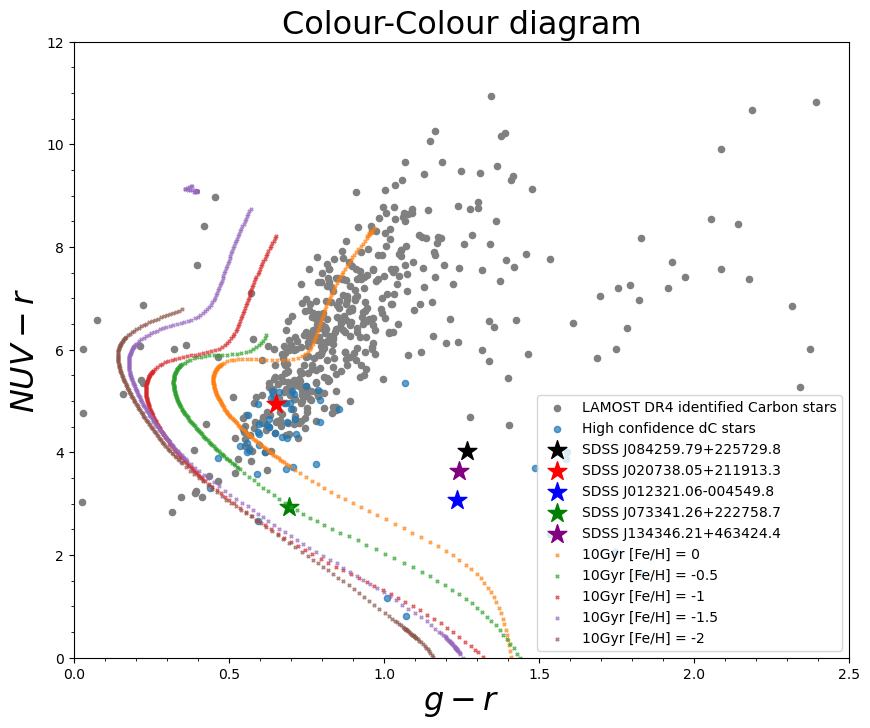

In [11]:

plt.figure(figsize=(10, 8))
plt.xlim(0,2.5)
plt.ylim(0,12)
plt.scatter(galex_df['g-r'], galex_df['NUV-r'], s=20, label='LAMOST DR4 identified Carbon stars', color='grey')
plt.scatter(merged_data['g-r'], merged_data['NUV-r'], s=20, alpha=0.7, label='High confidence dC stars')
plt.scatter(system['g-r'] , system['NUV-r'], s=200, label='SDSS J084259.79+225729.8', color='black',  marker='*')
plt.scatter(system2['g-r'] , system2['NUV-r'], s=200, label='SDSS J020738.05+211913.3', color='red',  marker='*')
plt.scatter(system3['g-r'] , system3['NUV-r'], s=200, label='SDSS J012321.06-004549.8', color='blue',  marker='*')
plt.scatter(system4['g-r'] , system4['NUV-r'], s=200, label='SDSS J073341.26+222758.7', color='green',  marker='*')
plt.scatter(system5['g-r'] , system5['NUV-r'], s=200, label='SDSS J134346.21+463424.4', color='purple',  marker='*')
plt.scatter(df_restricted2['g-r']  , df_restricted2['NUV-r'] , s=5, alpha=0.7, label='10Gyr [Fe/H] = 0',  marker='x')
plt.scatter(df_restricted4['g-r']  , df_restricted4['NUV-r'] , s=5, alpha=0.7, label='10Gyr [Fe/H] = -0.5', marker='x')
plt.scatter(df_restricted['g-r']  , df_restricted['NUV-r'] , s=5, alpha=0.7, label='10Gyr [Fe/H] = -1', marker='x')
plt.scatter(df_restricted3['g-r']  , df_restricted3['NUV-r'] , s=5, alpha=0.7, label='10Gyr [Fe/H] = -1.5', marker='x')
plt.scatter(df_restricted5['g-r']  , df_restricted5['NUV-r'] , s=5, alpha=0.7, label='10Gyr [Fe/H] = -2',  marker='x')
plt.xlabel('$g - r$', fontsize=23)
plt.ylabel('$NUV - r$', fontsize=23)
plt.title('Colour-Colour diagram', fontsize=23)
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))  
plt.legend()
plt.show()


In [12]:
# Calculate z-scores for the 'g-r' column
merged_data['g-r_z'] = zscore(merged_data['g-r'])
merged_data['NUV-r_z'] = zscore(merged_data['NUV-r'])


In [13]:
median_gr = np.median(merged_data['g-r'])
mad_gr = median_abs_deviation(merged_data['g-r'], scale=1)
merged_data['g-r_mod_z'] = 0.6745 * (merged_data['g-r'] - median_gr) / mad_gr

median_nuvr = np.median(merged_data['NUV-r'])
mad_NUVr = median_abs_deviation(merged_data['NUV-r'], scale=1)
merged_data['NUV-r_mod_z'] = 0.6745 * (merged_data['NUV-r'] - median_nuvr) / mad_NUVr


In [14]:

threshold = 1
outliers_nuvr = merged_data[np.abs(merged_data['NUV-r_mod_z']) > threshold]



/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/397523165.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted['g-r'] = df_restricted['sdss_g'] - df_restricted['sdss_r']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/397523165.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_restricted['r-i'] = df_restricted['sdss_r'] - df_restricted['sdss_i']
/var/folders/84/vq97xygs47z309flmqr4g_m80000gn/T/ipykernel_11828/397523165.py:5: SettingWithCopyWarning: 
A valu

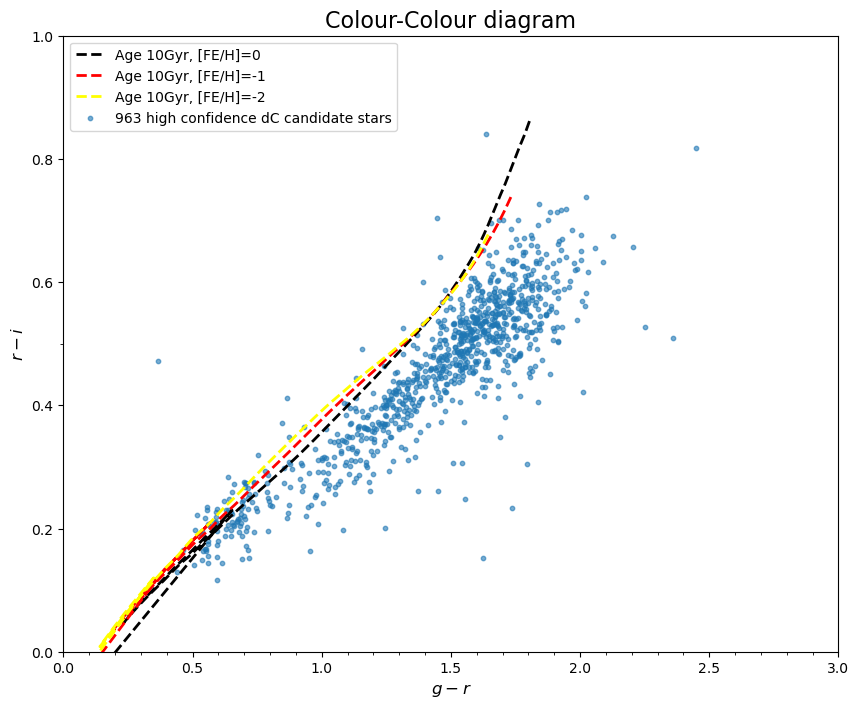

In [15]:
# [Fe/H] = -1
df_restricted['g-r'] = df_restricted['sdss_g'] - df_restricted['sdss_r']
df_restricted['r-i'] = df_restricted['sdss_r'] - df_restricted['sdss_i']

df_restricted2['r-i'] = df_restricted2['SDSS_r'] - df_restricted2['SDSS_i']
df_restricted2['g-r'] = df_restricted2['SDSS_g'] - df_restricted2['SDSS_r']


df_restricted5['r-i'] = df_restricted5['SDSS_r'] - df_restricted5['SDSS_i']
df_restricted5['g-r'] = df_restricted5['SDSS_g'] - df_restricted5['SDSS_r']

sdss_df['g-r'] = sdss_df['gpmag'] - sdss_df['rpmag']
sdss_df['r-i'] = sdss_df['rpmag'] - sdss_df['ipmag']

plt.figure(figsize=(10, 8))
plt.xlim(0, 3)  
plt.ylim(0, 1) 
plt.plot(df_restricted['g-r'], df_restricted['r-i'],linestyle='dashed', linewidth=2, color='black', label='Age 10Gyr, [FE/H]=0')
plt.plot(df_restricted3['g-r'], df_restricted3['r-i'],linestyle='dashed', linewidth=2, color='red', label='Age 10Gyr, [FE/H]=-1')
plt.plot(df_restricted5['g-r'], df_restricted5['r-i'],linestyle='dashed', linewidth=2, color='yellow', label='Age 10Gyr, [FE/H]=-2')
plt.scatter(sdss_df['g-r'], sdss_df['r-i'] , s=10, alpha=0.6, label='963 high confidence dC candidate stars') 
plt.xlabel('$g - r$', fontsize=12)
plt.ylabel('$r - i$', fontsize=12)
plt.title('Colour-Colour diagram', fontsize=16)
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))  
plt.legend()
plt.show()

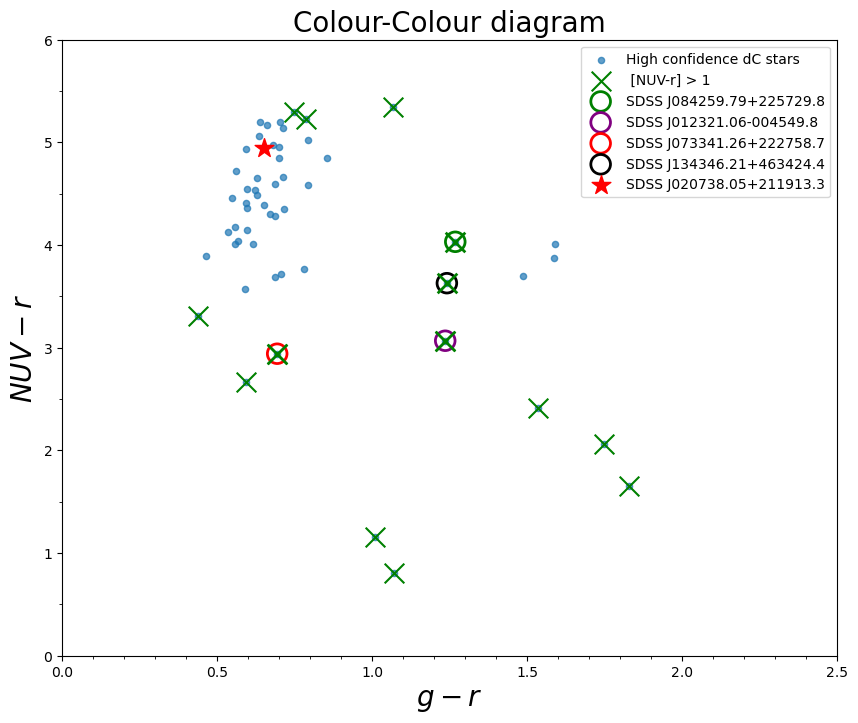

In [16]:


plt.figure(figsize=(10, 8))
plt.xlim(0, 2.5)
plt.ylim(0, 6)
plt.scatter(merged_data['g-r'], merged_data['NUV-r'], s=20, alpha=0.7, label='High confidence dC stars')
plt.scatter(outliers_nuvr['g-r'], outliers_nuvr['NUV-r'], s=200, marker='x',color='green', label=' [NUV-r] > 1')
plt.scatter(system['g-r'], system['NUV-r'], s=200, label='SDSS J084259.79+225729.8', marker='o', edgecolor='green', facecolor='none', linewidths=2) 
plt.scatter(system['g-r'], system['NUV-r'], s=200,  marker='x', color='green', linewidths=2) 
plt.scatter(system3['g-r'], system3['NUV-r'], s=200, label='SDSS J012321.06-004549.8', marker='o', edgecolor='purple', facecolor='none', linewidths=2) 
plt.scatter(system3['g-r'], system3['NUV-r'], s=200,  marker='x', color='green', linewidths=2)  
plt.scatter(system4['g-r'], system4['NUV-r'], s=200, label='SDSS J073341.26+222758.7', marker='o', edgecolor='red', facecolor='none', linewidths=2) 
plt.scatter(system4['g-r'], system4['NUV-r'], s=200, marker='x', color='green', linewidths=2) 
plt.scatter(system5['g-r'], system5['NUV-r'], s=200, label='SDSS J134346.21+463424.4', marker='o', edgecolor='black', facecolor='none', linewidths=2)
plt.scatter(system2['g-r'] , system2['NUV-r'], s=200, label='SDSS J020738.05+211913.3', color='red',  marker='*')
plt.scatter(system5['g-r'], system5['NUV-r'], s=200,  marker='x', color='green', linewidths=2) 
plt.xlabel('$g - r$', fontsize=20)
plt.ylabel('$NUV - r$', fontsize=20)
plt.title('Colour-Colour diagram', fontsize=20)
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))  
plt.legend()
plt.show()


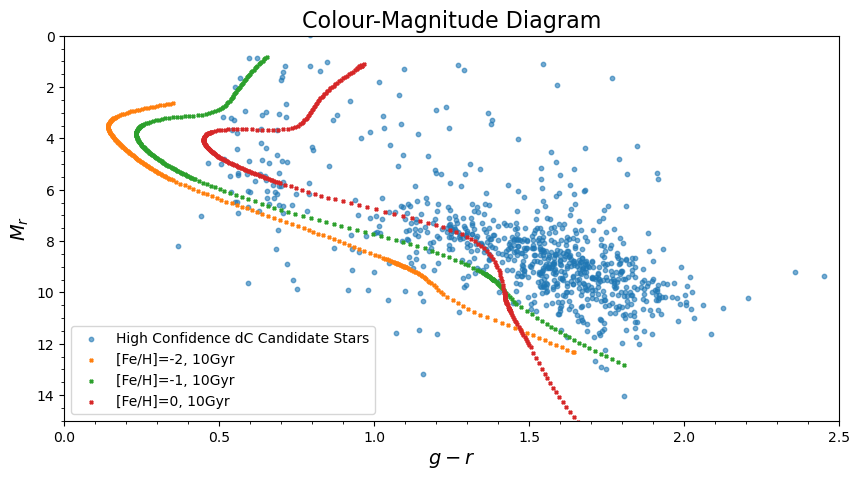

In [17]:

gaiadata = '/Users/amberbarlow/Downloads/hugedata1.fits'  
gaiadata_table = Table.read(gaiadata)
hugedata = gaiadata_table.to_pandas()


hugedata['distance_pc'] = 1000.0 / hugedata['parallax']
hugedata = hugedata[hugedata['distance_pc'] > 0]
hugedata['M_gmag'] = hugedata['gpmag'] - 5 * np.log10(hugedata['distance_pc']) + 5
hugedata['M_rmag'] = hugedata['rpmag'] - 5 * np.log10(hugedata['distance_pc']) + 5
hugedata['g-r'] = hugedata['gpmag'] - hugedata['rpmag']


plt.figure(figsize=(10, 5))
plt.scatter(hugedata['g-r'], hugedata['M_rmag'],s=10, alpha=0.6, label='High Confidence dC Candidate Stars')
plt.scatter(df_restricted5['g-r'], df_restricted5['SDSS_r'], s=5, label='[Fe/H]=-2, 10Gyr', marker='X')
plt.scatter(df_restricted['g-r'], df_restricted['sdss_r'], s=5, label='[Fe/H]=-1, 10Gyr', marker='X')
plt.scatter(df_restricted2['g-r'], df_restricted2['SDSS_r'], s=5, label='[Fe/H]=0, 10Gyr', marker='X')
plt.xlabel('$g - r$', fontsize=14)
plt.ylabel('$M_r$', fontsize=14)
plt.title('Colour-Magnitude Diagram', fontsize=16)
plt.legend()
plt.xlim(0, 2.5) 
plt.ylim(0, 15) 
plt.gca().invert_yaxis() 
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))  
plt.show()

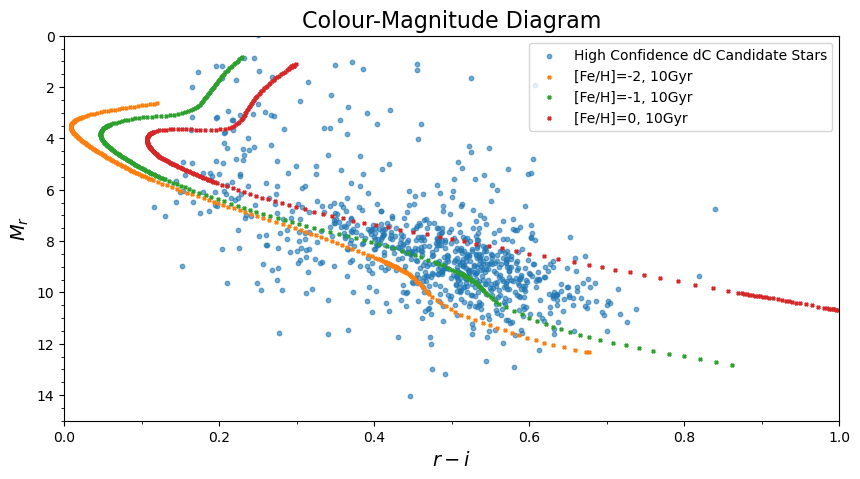

In [18]:

hugedata['r-i'] = hugedata['rpmag'] - hugedata['ipmag']


plt.figure(figsize=(10, 5))
plt.scatter(hugedata['r-i'], hugedata['M_rmag'],s=10, alpha=0.6, label='High Confidence dC Candidate Stars')
plt.scatter(df_restricted5['r-i'], df_restricted5['SDSS_r'], s=5, label='[Fe/H]=-2, 10Gyr', marker='X')
plt.scatter(df_restricted['r-i'], df_restricted['sdss_r'], s=5, label='[Fe/H]=-1, 10Gyr', marker='X')
plt.scatter(df_restricted2['r-i'], df_restricted2['SDSS_r'], s=5, label='[Fe/H]=0, 10Gyr', marker='X')
plt.xlabel('$r - i$', fontsize=14)
plt.ylabel('$M_r$', fontsize=14)
plt.title('Colour-Magnitude Diagram', fontsize=16)
plt.legend()
plt.xlim(0, 1) 
plt.ylim(0, 15) 
plt.gca().invert_yaxis() 
ax = plt.gca()
ax.xaxis.set_minor_locator(ticker.MultipleLocator(base=0.1))  
ax.yaxis.set_minor_locator(ticker.MultipleLocator(base=0.5))  
plt.show()

# spectral energy distributions (SED)

## J0842

In [19]:
#constants 
parsecs_cm = 3.0857e18
c = 3e10   

In [20]:
def galex_vals(ra, dec):
    """
    Queries GALEX for UV FUV and NUV data given the right ascension (ra) an declination (dec)
    
    Inputs:
    ra: right ascension (degrees)
    dec: declination (degrees)
    
    Outputs:
    fuv_mag_mean: weighted average of the fuv magnitude
    fuv_mag_err_weighted: weighted average of the error in fuv magnitude 
    nuv_mag_mean: weighted average of the nuv magnitude
    nuv_mag_err_weighted: weighted average of the error in nuv magnitude 
    fuv_flux_mean: weighted average of the fuv flux 
    fuv_flux_err_weighted: weighted average of the fuv flux error 
    nuv_flux_mean: weighted average of the nuv flux 
    nuv_flux_err_weighted: weighted average of the nuv flux error 

    """
    #query galex 
    galex_query = Catalogs.query_object(f"{ra} {dec}", radius=1*u.arcsec, catalog="Galex")
    
    fuv_mag = np.array(galex_query['fuv_mag'])
    nuv_mag = np.array(galex_query['nuv_mag'])
    e_fuv_mag = np.array(galex_query['fuv_magerr'])
    e_nuv_mag = np.array(galex_query['nuv_magerr'])
    
    fuv_flux = np.array(galex_query['fuv_flux'])
    nuv_flux = np.array(galex_query['nuv_flux'])
    fuv_flux_err = np.array(galex_query['fuv_fluxerr'])
    nuv_flux_err = np.array(galex_query['nuv_fluxerr'])
    
    #valid data filters 
    valid_fuv = (fuv_mag > 0) & (e_fuv_mag > 0) & (fuv_flux > 0) & (fuv_flux_err > 0)
    valid_nuv = (nuv_mag > 0) & (e_nuv_mag > 0) & (nuv_flux > 0) & (nuv_flux_err > 0)
    
    #filtering for valid data 
    fuv_mag_filtered = fuv_mag[valid_fuv]
    nuv_mag_filtered = nuv_mag[valid_nuv]
    e_fuv_mag_filtered = e_fuv_mag[valid_fuv]
    e_nuv_mag_filtered = e_nuv_mag[valid_nuv]
    
    #filtering for valid data 
    fuv_flux_filtered = fuv_flux[valid_fuv]
    nuv_flux_filtered = nuv_flux[valid_nuv]
    fuv_flux_err_filtered = fuv_flux_err[valid_fuv]
    nuv_flux_err_filtered = nuv_flux_err[valid_nuv]
    
    #calculating weighted errors in magnitude
    fuv_weights = 1 / (e_fuv_mag_filtered**2)
    nuv_weights = 1 / (e_nuv_mag_filtered**2)
    
    #calculating weighted average in magnitude
    fuv_mag_mean = np.average(fuv_mag_filtered, weights=fuv_weights)
    nuv_mag_mean = np.average(nuv_mag_filtered, weights=nuv_weights)
    
    #calculating weighted errors 
    fuv_mag_err_weighted = np.sqrt(1 / np.sum(fuv_weights))
    nuv_mag_err_weighted = np.sqrt(1 / np.sum(nuv_weights))
    
    #calculating weighted errors
    fuv_flux_weights = 1 / (fuv_flux_err_filtered**2)
    nuv_flux_weights = 1 / (nuv_flux_err_filtered**2)
    
    #calculating weighted average in flux
    fuv_flux_mean = np.average(fuv_flux_filtered, weights=fuv_flux_weights)
    nuv_flux_mean = np.average(nuv_flux_filtered, weights=nuv_flux_weights)

    #calculating weighted errors in flux
    fuv_flux_err_weighted = np.sqrt(1 / np.sum(fuv_flux_weights))
    nuv_flux_err_weighted = np.sqrt(1 / np.sum(nuv_flux_weights))
    
    return (fuv_mag_mean, fuv_mag_err_weighted,
            nuv_mag_mean, nuv_mag_err_weighted,
            fuv_flux_mean, fuv_flux_err_weighted,
            nuv_flux_mean, nuv_flux_err_weighted)


def load_synthetic_model(fits_file):
    """
    loading a synthetic model with the flux in erg/cm^2/s/Å and converting it into flux in mJy.
    Inputs:
    fits_file: fits file 
    flux_col: surface gravity 
    
    Outputs:
    wave_um: wavelength in micrometers
    flux_mjy: flux density in mJy
    """
    with fits.open(fits_file) as hdul:
        data_model = hdul[1].data
        wavelength_A = data_model['WAVELENGTH']  
        flux_lambda = data_model['g50'] 

    wavelength_cm = wavelength_A * 1e-8 
    flux_mjy = flux_lambda*(wavelength_cm**2 / 3e10)*1e26  

    wavelength_um = wavelength_A * 1e-4  
    return wavelength_um, flux_mjy

def synthetic_photometry(synthetic_wavelength_A, synthetic_flux_mjy, filter_wavelength_A, filter_response):
    """
    Calculates the synthetic flux in mJy
    
    Inputs:
    synthetic_wavelength_A: wavelength of synthetic flux in angstroms
    synthetic_flux_mjy: flux in mjy
    filter_wavelength_A: wavelength of transmission curve in angstroms
    filter_response: response of the filter curve 
    
    Outputs:
    F_mjy = flux density in mjy 
    
    """
    interpolated_response = np.interp(synthetic_wavelength_A, filter_wavelength_A, filter_response)
    numerator = simps(interpolated_response * synthetic_flux_mjy, synthetic_wavelength_A)
    denominator = simps(interpolated_response, synthetic_wavelength_A)
    F_mjy = numerator / denominator
    return F_mjy


def flux_density_mjy(pmag):
    """
    Convert AB magnitude to flux density in mJy.
    Inputs:
    pmag: psf magnitude
    Outputs:
    fd_mjy = flux density in mJy
    """
    fd_mjy = 10 ** ((8.90 - pmag) / 2.5 + 3)
    return fd_mjy

def error_prop_sdss(pmag, pmag_e):
    """
    Convert SDSS mag error to flux error in mJy
    Inputs:
    pmag: psf magnitude 
    pmag_e: psf magnitude error
    Outputs:
    e_sys: total error for sdss flux densities
    """
    f_mjy = flux_density_mjy(pmag)
    f_mjy_e = f_mjy * np.log(10) * 0.4 * pmag_e
    sys = f_mjy*0.2
    e_sys = np.sqrt(sys**2+f_mjy_e**2)
    return e_sys

def error_prop_galex(pmag, pmag_e):
    """
    Flux density error for GALEX psf magnitudes
    Inputs:
    pmag: psf magnitude
    pmag_e: psf magnitude error 
    Outputs:
    e_sys: total GALEX flux density error 
    """
    f_mjy = flux_density_mjy(pmag)
    f_mjy_e = f_mjy * np.log(10) * 0.4 * pmag_e
    sys = f_mjy*0.3
    e_sys = np.sqrt(sys**2+f_mjy_e**2)
    return e_sys


def spectrum(ra, dec):
    """
    Getting the SDSS spectrum
    Inputs:
    ra: right ascension
    dec: declination
    
    Outputs:
    spec: SDSS spectrum
    """
    coord = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs')
    search_rad = 1 * u.arcsec
    query = SDSS.query_region(coord, spectro=True, radius=search_rad)
    spec = SDSS.get_spectra(matches=query)
    return spec

def chi2_comb(parameters, wd_wavelength_A, wd_flux, fehminus1_wave_um, fehminus1_flux_mjy,
              fuv_data, nuv_data, u_data, g_data, r_data, i_data, z_data,
              observed_fluxes, sdss_error, observed_galex, err_galex):
    """
    calculates the composite chi squared for the combined main-sequence and white dwarf model in comparison to the S
    SDSS and GALEX photometry
    
    Inputs:
    parameters: tuple of the initial guesses for the white dwarf and main-sequence scale factors
    wd_wavelength_A: wavelength of the white dwarf in angstroms
    wd_flux: flux density of the white dwarf in mJy
    fehminus1_wave_um: wavelength of the main-sequence model in micrometers (um)
    fehminus1_flux_mjy: flux density of the main-sequence model in mJy
    fuv_data, nuv_data, u_data, g_data, r_data, i_data, z_data : filter response data for the SDSS photometric bands
    observed_fluxes: sdss fluxes
    sdss_error: sdss flux errors
    observed_galex: galex fluxes
    err_galex: galex flux errors
    
    Outputs:
    chi2_total: combined chi squared value
    """
    sf_wd, sf_ms = parameters
    ms1_wavelength_A = fehminus1_wave_um * 1e4
    ms1_interp = interp1d(ms1_wavelength_A, fehminus1_flux_mjy, kind='linear',fill_value="extrapolate")
    ms1_flux_interp = ms1_interp(wd_wavelength_A)
    composite_flux = (sf_wd * wd_flux) + (sf_ms * ms1_flux_interp)
    
    synthetic_fuv = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        fuv_data['Wavelength_A'], fuv_data['Response']
    )
    synthetic_nuv = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        nuv_data['Wavelength_A'], nuv_data['Response']
    )
    
    u_flux = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        u_data['Wavelength_A'], u_data['Response']
    )
    g_flux = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        g_data['Wavelength_A'], g_data['Response']
    )
    r_flux = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        r_data['Wavelength_A'], r_data['Response']
    )
    i_flux = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        i_data['Wavelength_A'], i_data['Response']
    )
    z_flux = synthetic_photometry(
        wd_wavelength_A, composite_flux,
        z_data['Wavelength_A'], z_data['Response']
    )
    
    synthetic_galex = np.array([synthetic_fuv, synthetic_nuv])
    synthetic_sdss = np.array([g_flux, r_flux, i_flux, z_flux])
    
    chi2_sdss = np.sum(((synthetic_sdss - observed_fluxes)**2) / (sdss_error**2))
    chi2_galex = np.sum(((synthetic_galex - observed_galex)**2) / (err_galex**2))
    chi2_total = chi2_sdss + chi2_galex
    
    return chi2_total

In [21]:

sdss_data = '/Users/amberbarlow/Downloads/coordinates.fits'
sdss_data_table = Table.read(sdss_data)
sdss_df = sdss_data_table.to_pandas()

galex_data = '/Users/amberbarlow/Downloads/galexcorrect.fits'
galex_data_table = Table.read(galex_data)
galex_df = galex_data_table.to_pandas()

merged_df = pd.merge(sdss_df, galex_df, on=['RA_degrees', 'Dec_degrees'], how='inner')
system = merged_df[merged_df["objID"] == 1237673809196089561]
fuv_mag, e_fuv_mag, nuv_mag, e_nuv_mag, fuv_flux, e_fuv_flux, nuv_flux, e_nuv_flux = galex_vals(130.749142, 22.958279)

#flux density in mjy for all photometry
fd_fuv = flux_density_mjy(fuv_mag)  
fd_nuv = flux_density_mjy(nuv_mag)
fd_u = flux_density_mjy(system["upmag"].iloc[0])
fd_g = flux_density_mjy(system["gpmag"].iloc[0])
fd_r = flux_density_mjy(system["rpmag"].iloc[0])
fd_i = flux_density_mjy(system["ipmag"].iloc[0])
fd_z = flux_density_mjy(system["zpmag"].iloc[0])

# photometric errors
e_fuv = error_prop_galex(system["FUVmag"].iloc[0], system["e_FUVmag"].iloc[0])
e_nuv = error_prop_galex(system["NUVmag"].iloc[0], system["e_NUVmag"].iloc[0])
e_upmag = error_prop_sdss(system["upmag"].iloc[0], system["e_upmag"].iloc[0])
e_gpmag = error_prop_sdss(system["gpmag"].iloc[0], system["e_gpmag"].iloc[0])
e_rpmag = error_prop_sdss(system["rpmag"].iloc[0], system["e_rpmag"].iloc[0])
e_ipmag = error_prop_sdss(system["ipmag"].iloc[0], system["e_ipmag"].iloc[0])
e_zpmag = error_prop_sdss(system["zpmag"].iloc[0], system["e_zpmag"].iloc[0])

In [22]:

wavelengths_sdss = { "g": 4770, "r": 6231, "i": 7625, "z": 9134}
wavelength_um_sdss = np.array(list(wavelengths_sdss.values())) / 1e4
wavelengths_sdss_full = {"u": 3543, "g": 4770, "r": 6231, "i": 7625, "z": 9134}
wavelength_um_sdss_full = np.array(list(wavelengths_sdss_full.values())) / 1e4

wavelengths_galex = {"FUV": 1538.6, "NUV": 2315.7}
wavelength_um_galex = np.array(list(wavelengths_galex.values())) / 1e4


In [23]:

# Define file paths
wd_model = '/Users/amberbarlow/Downloads/da12000_800.dat'
galex_fuv_response = '/Users/amberbarlow/Downloads/galex_fuv.dat'
galex_nuv_response = '/Users/amberbarlow/Downloads/galex_nuv.dat'

wd_data = pd.read_csv(wd_model, delim_whitespace=True, header=None, names=['Wavelength_um', 'F_nu_mJy'])
wd_wavelength_A = wd_data['Wavelength_um']*1e4
wd_wavelength = wd_data['Wavelength_um']

# Load filter response data
fuv_data = pd.read_csv(galex_fuv_response, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])
nuv_data = pd.read_csv(galex_nuv_response, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])


# Perform synthetic photometry for FUV and NUV
fuv_flux = synthetic_photometry(
    wd_wavelength_A,
    wd_data['F_nu_mJy'],
    fuv_data['Wavelength_A'],
    fuv_data['Response']
)

nuv_flux = synthetic_photometry(
    wd_wavelength_A,
    wd_data['F_nu_mJy'],
    nuv_data['Wavelength_A'],
    nuv_data['Response']
)


observed_galex = np.array([fd_fuv, fd_nuv])
model_galex = np.array([fuv_flux, nuv_flux])


In [24]:
u_band = '/Users/amberbarlow/Downloads/SLOAN_SDSS.u.dat'
g_band = '/Users/amberbarlow/Downloads/SLOAN_SDSS.g.dat'
r_band = '/Users/amberbarlow/Downloads/SLOAN_SDSS.r.dat'
i_band = '/Users/amberbarlow/Downloads/SLOAN_SDSS.i.dat'
z_band = '/Users/amberbarlow/Downloads/SLOAN_SDSS.z.dat'
u_data = pd.read_csv(u_band, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])
g_data = pd.read_csv(g_band, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])
r_data = pd.read_csv(r_band, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])
i_data = pd.read_csv(i_band, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])
z_data = pd.read_csv(z_band, delim_whitespace=True, header=None, names=['Wavelength_A', 'Response'])


fehminus1_file = '/Users/amberbarlow/Downloads/metalicity.fits'
fehminus1_wave_um, fehminus1_flux_mjy = load_synthetic_model(fehminus1_file)
fehminus1_wave_A = fehminus1_wave_um*1e4

u_flux = synthetic_photometry(
    fehminus1_wave_A,
    fehminus1_flux_mjy,
    u_data['Wavelength_A'],
    u_data['Response']
)

g_flux = synthetic_photometry(
    fehminus1_wave_A,
    fehminus1_flux_mjy,
    g_data['Wavelength_A'],
    g_data['Response']
)

r_flux = synthetic_photometry(
    fehminus1_wave_A,
    fehminus1_flux_mjy,
    r_data['Wavelength_A'],
    r_data['Response']
)

i_flux = synthetic_photometry(
    fehminus1_wave_A,
    fehminus1_flux_mjy,
    i_data['Wavelength_A'],
    i_data['Response']
)

z_flux = synthetic_photometry(
    fehminus1_wave_A,
    fehminus1_flux_mjy,
    z_data['Wavelength_A'],
    z_data['Response']
)


In [25]:
observed_galex = np.array([fd_fuv, fd_nuv])
err_galex = np.array([e_fuv, e_nuv])

model_galex = np.array([fuv_flux, nuv_flux])

observed_fluxes_sdss = np.array([fd_u, fd_g, fd_r, fd_i, fd_z])
observed_fluxes_sdss_filt = np.array([fd_g, fd_r, fd_i, fd_z])
observed_fluxes_sdss_e = np.array([e_upmag, e_gpmag, e_rpmag, e_ipmag, e_zpmag])
observed_fluxes_sdss_e_filt = np.array([e_gpmag, e_rpmag, e_ipmag, e_zpmag])

model_flux = np.array([g_flux, r_flux, i_flux, z_flux])
model_flux_full = np.array([u_flux, g_flux, r_flux, i_flux, z_flux])

In [26]:

ms_models = [
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "4000K", "file": "/Users/amberbarlow/Downloads/spectramodel.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "4250K", "file": "/Users/amberbarlow/Downloads/kp00_4250.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "4500K", "file": "/Users/amberbarlow/Downloads/kp00_4500.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "4750K", "file": "/Users/amberbarlow/Downloads/kp00_4750.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "5000K", "file": "/Users/amberbarlow/Downloads/kp00_5000.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "5250K", "file": "/Users/amberbarlow/Downloads/kp00_5250.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = 0",  "temperature": "5500K", "file": "/Users/amberbarlow/Downloads/kp00_5500.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "4000K", "file": "/Users/amberbarlow/Downloads/km01_4000.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "4250K", "file": "/Users/amberbarlow/Downloads/km01_4250.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "4250K", "file": "/Users/amberbarlow/Downloads/km01_4500.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "4750K", "file": "/Users/amberbarlow/Downloads/km01_4750.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "5000K", "file": "/Users/amberbarlow/Downloads/km01_5000.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "5250K", "file": "/Users/amberbarlow/Downloads/km01_5250.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -1", "temperature": "5500K", "file": "/Users/amberbarlow/Downloads/km01_5500.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "4000K", "file": "/Users/amberbarlow/Downloads/km02_4000.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "4250K", "file": "/Users/amberbarlow/Downloads/km02_4250.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "4500K", "file": "/Users/amberbarlow/Downloads/km02_4500.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "4750K", "file": "/Users/amberbarlow/Downloads/km02_4750.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "5000K", "file": "/Users/amberbarlow/Downloads/km02_5000.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "5250K", "file": "/Users/amberbarlow/Downloads/km02_5250.fits"},
    {"model": "MS", "metallicity": "[Fe/H] = -2", "temperature": "5500K", "file": "/Users/amberbarlow/Downloads/km02_5500.fits"},
]


wd_models = [
    {"model": "WD",  "temperature": "7000K", "file": "/Users/amberbarlow/Downloads/da07000_800.dat"},
    {"model": "WD",  "temperature": "8000K", "file": "/Users/amberbarlow/Downloads/da08000_800 (1).dat"},
    {"model": "WD",  "temperature": "9000K", "file": "/Users/amberbarlow/Downloads/da09000_800 (3).dat"},
    {"model": "WD",  "temperature": "10000K", "file": "/Users/amberbarlow/Downloads/da10000_800.dat"},
    {"model": "WD",  "temperature": "11000K", "file": "/Users/amberbarlow/Downloads/da11000_800.dat"},
    {"model": "WD",  "temperature": "12000K", "file": "/Users/amberbarlow/Downloads/da12000_800.dat"},
    {"model": "WD",  "temperature": "13000K", "file": "/Users/amberbarlow/Downloads/da13000_800.dat"},
    {"model": "WD",  "temperature": "14000K", "file": "/Users/amberbarlow/Downloads/da14000_800.dat"},
    {"model": "WD",  "temperature": "15000K", "file": "/Users/amberbarlow/Downloads/da15000_800.dat"},
    {"model": "WD",  "temperature": "16000K", "file": "/Users/amberbarlow/Downloads/da16000_800.dat"},
    {"model": "WD",  "temperature": "17000K", "file": "/Users/amberbarlow/Downloads/da17000_800.dat"},
]

In [27]:
composite_results_2 = []

for wd_model in wd_models:
    wd_label = "WD"
    if wd_model['temperature']:
        wd_label += f", {wd_model['temperature']}"
    wd_data = pd.read_csv(wd_model["file"], delim_whitespace=True, header=None, 
                          names=['Wavelength_um', 'F_nu_mJy'])
    wd_wavelength_A = wd_data['Wavelength_um'].values * 1e4  
    wd_flux = wd_data['F_nu_mJy'].values         
    n_ms = len(ms_models)
    for i in range(n_ms):
        ms1_model = ms_models[i]
        ms1_label = "MS1"
        if ms1_model['metallicity']:
            ms1_label += f", {ms1_model['metallicity']}"
        if ms1_model['temperature']:
            ms1_label += f", {ms1_model['temperature']}"
        ms1_wave, ms1_flux = load_synthetic_model(ms1_model["file"])
        initial_params = [5.4e1, 3.3e-14] 
        result = minimize(chi2_comb, initial_params,
                  args=(wd_wavelength_A, wd_flux, ms1_wave, ms1_flux,
                        fuv_data, nuv_data, u_data, g_data, r_data, i_data, z_data,
                        observed_fluxes_sdss_filt, observed_fluxes_sdss_e_filt, observed_galex, err_galex),
                  method='Nelder-Mead')

        composite_results_2.append({
            "wd_label": wd_label,
            "ms1_label": ms1_label,
            "wd_temperature": wd_model["temperature"],
            "ms1_metallicity": ms1_model["metallicity"],
            "ms1_temperature": ms1_model["temperature"],
            "scale_wd": result.x[0],
            "scale_ms1": result.x[1],
            "chi2": result.fun
        })

In [28]:

best_results = sorted(composite_results_2, key=lambda x: x["chi2"])
best = best_results[0]
print("\nThe best model combination:")
print(f"Optimal WD model: {best['wd_label']}")
print(f"Optimal MS model: {best['ms1_label']}")
print(f"Scale factors  WD: {best['scale_wd']:.3e}, MS1: {best['scale_ms1']:.3e}")
print(f"Chi²: {best['chi2']:.3f}")

wd_temp = best['wd_label']
scale_wd = best['scale_wd']
scale_ms1 = best['scale_ms1']
ms1_metallicity = best['ms1_metallicity']
ms1_temperature = best['ms1_temperature']


The best model combination:
Optimal WD model: WD, 12000K
Optimal MS model: MS1, [Fe/H] = -2, 4000K
Scale factors  WD: 5.390e+01, MS1: 3.322e-14
Chi²: 0.038


In [29]:
filtered_models = []
for result in composite_results_2:
    if (result["ms1_temperature"] == ms1_temperature and
        result["ms1_metallicity"] != ms1_metallicity and
        result["wd_label"] == wd_temp):
        filtered_models.append(result)


best_model = filtered_models[0]
print("\nFiltered best model alternative:")
print(f"Optimal WD model: {best_model['wd_label']}")
print(f"Optimal MS model: {best_model['ms1_label']}")
print(f"Scale factors WD: {best_model['scale_wd']:.3e}, MS1: {best_model['scale_ms1']:.3e}")
print(f"Chi²: {best_model['chi2']:.3f}")
scale_ms2 = best_model['scale_ms1']



Filtered best model alternative:
Optimal WD model: WD, 12000K
Optimal MS model: MS1, [Fe/H] = 0, 4000K
Scale factors WD: 5.411e+01, MS1: 3.265e-14
Chi²: 0.215


In [30]:
#optimal wd model
wd_model = '/Users/amberbarlow/Downloads/da12000_800.dat'
wd_data = pd.read_csv(wd_model, delim_whitespace=True, header=None, names=['Wavelength_um', 'F_nu_mJy'])
wd_wavelength_A = wd_data['Wavelength_um']*1e4
wd_wavelength_um = wd_data['Wavelength_um']
scaled_wd_flux = wd_data['F_nu_mJy']*scale_wd
wd_flux = wd_data['F_nu_mJy']


#sdss spectrum 
coordinates = SkyCoord(ra=130.749142, dec=22.958279, unit=('deg','deg'))
query = SDSS.query_region(coordinates, spectro=True, radius=1*u.arcsec)
spectra = SDSS.get_spectra(matches=query)
spectra[0].writeto('star_spectrum1.fits', overwrite=True)

h = fits.open('star_spectrum1.fits')
spec_data = h[1].data
h.close()

loglam    = spec_data['loglam']           
flux_spec = spec_data['flux']            

wave_A_spec  = 10**loglam
wave_um_spec = wave_A_spec / 1e4
wave_cm_spec = wave_um_spec * 1e-4

flux_ergA_spec = flux_spec * 1e-17
spec_flux_mjy = flux_ergA_spec * 1e8 * (wave_cm_spec**2 / c) * 1e26

In [31]:
# Define file paths for the WD model.
wd_model = '/Users/amberbarlow/Downloads/da12000_800.dat'
wd_data = pd.read_csv(wd_model, delim_whitespace=True, header=None, names=['Wavelength_um', 'F_nu_mJy'])
wd_wavelength_A = wd_data['Wavelength_um'] * 1e4
wd_wavelength_um = wd_data['Wavelength_um']
scaled_wd_flux = wd_data['F_nu_mJy'] * scale_wd
wd_flux = wd_data['F_nu_mJy']


In [32]:
fehminus1_file = '/Users/amberbarlow/Downloads/km01_4000.fits'
fehminus1_wave_um, fehminus1_flux_mjy = load_synthetic_model(fehminus1_file)

fehminus2_file = '/Users/amberbarlow/Downloads/km02_4000.fits'
fehminus2_wave_um, fehminus2_flux_mjy = load_synthetic_model(fehminus2_file)

scaled_ms1_mjy = fehminus2_flux_mjy*scale_ms2
scaled_ms2_mjy = fehminus1_flux_mjy*scale_ms1

In [33]:

# Interpolate metallicity models to match WD wavelength grid
feh1_interp = interp1d(fehminus1_wave_um, scaled_ms1_mjy, kind='linear', fill_value="extrapolate")
feh2_interp = interp1d(fehminus2_wave_um, scaled_ms2_mjy, kind='linear', fill_value="extrapolate")

# Interpolated fluxes
feh1_flux_interpolated = feh1_interp(wd_wavelength_um)
feh2_flux_interpolated = feh2_interp(wd_wavelength_um)

# Combine fluxes directly with WD spectrum
combined_feh1_flux = feh1_flux_interpolated + scaled_wd_flux
combined_feh2_flux = feh2_flux_interpolated + scaled_wd_flux


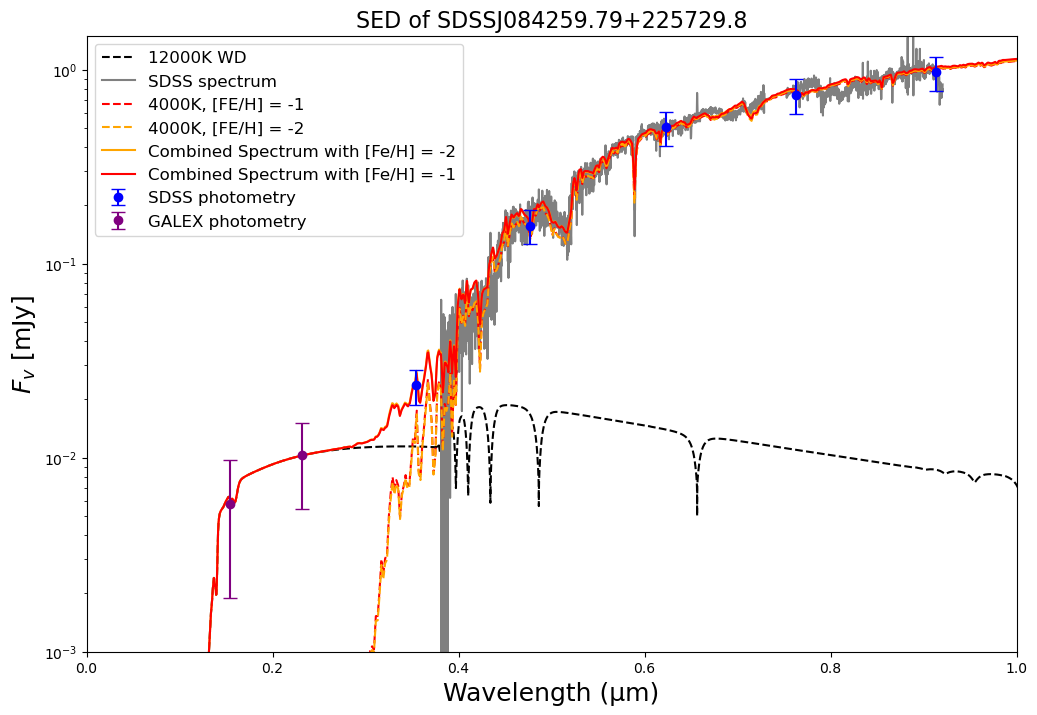

In [34]:

plt.figure(figsize=(12, 8))

plt.plot(
    wd_wavelength_um, scaled_wd_flux,
    color='black', linewidth=1.5, linestyle='dashed',
    label='12000K WD'
)


plt.plot(
    wave_um_spec, spec_flux_mjy ,
    color='grey', linewidth=1.5,
    label='SDSS spectrum'
)

plt.plot(
    fehminus2_wave_um, scaled_ms1_mjy,
    color='red', linewidth=1.5, linestyle='dashed',
    label='4000K, [FE/H] = -1'
)

plt.plot(
    fehminus1_wave_um, scaled_ms2_mjy,
    color='orange', linewidth=1.5, linestyle='dashed',
    label='4000K, [FE/H] = -2 '
)


plt.errorbar(
    wavelength_um_sdss_full,
    observed_fluxes_sdss,
    yerr=observed_fluxes_sdss_e,
    fmt='o', color='blue',
    capsize=5, elinewidth=1.5, zorder=10,
    label='SDSS photometry'
)

plt.errorbar(
    wavelength_um_galex,
    observed_galex,
    yerr=err_galex,
    fmt='o', color='purple',
    capsize=5, elinewidth=1.5, zorder=10,
    label='GALEX photometry'
)

plt.plot(
    wd_wavelength_um, combined_feh1_flux,
    color='orange', linewidth=1.5,
    label='Combined Spectrum with [Fe/H] = -2'
)

plt.plot(
    wd_wavelength_um, combined_feh2_flux,
    color='red', linewidth=1.5,
    label='Combined Spectrum with [Fe/H] = -1'
)



plt.yscale('log')
plt.xlim(0, 1.0)
plt.ylim(1e-3, 1.5)
plt.xlabel('Wavelength (µm)', fontsize=18)
plt.ylabel('${F_v}$ [mJy]', fontsize=18)
plt.title('SED of SDSSJ084259.79+225729.8', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# J0207

In [54]:
system_2 = merged_df[(merged_df["RA_degrees"] == 31.90854166666667) & (merged_df["Dec_degrees"] == 21.32036111111111)]
fuv_mag2, e_fuv_mag2, nuv_mag2, e_nuv_mag2, fuv_flux2, e_fuv_flux2, nuv_flux2, e_nuv_flux2 = galex_vals(31.90854166666667, 21.32036111111111)

fd_fuv2 = flux_density_mjy(fuv_mag2)  
fd_nuv2 = flux_density_mjy(nuv_mag2)
fd_u2 = flux_density_mjy(system_2["upmag"].iloc[0])
fd_g2 = flux_density_mjy(system_2["gpmag"].iloc[0])
fd_r2 = flux_density_mjy(system_2["rpmag"].iloc[0])
fd_i2 = flux_density_mjy(system_2["ipmag"].iloc[0])
fd_z2 = flux_density_mjy(system_2["zpmag"].iloc[0])

e_fuv2 = error_prop_galex(fuv_mag2, e_fuv_mag2)
e_nuv2 = error_prop_galex(nuv_mag2, e_nuv_mag2)
e_upmag2 = error_prop_sdss(system_2["upmag"].iloc[0], system_2["e_upmag"].iloc[0])
e_gpmag2 = error_prop_sdss(system_2["gpmag"].iloc[0], system_2["e_gpmag"].iloc[0])
e_rpmag2 = error_prop_sdss(system_2["rpmag"].iloc[0], system_2["e_rpmag"].iloc[0])
e_ipmag2 = error_prop_sdss(system_2["ipmag"].iloc[0], system_2["e_ipmag"].iloc[0])
e_zpmag2 = error_prop_sdss(system_2["zpmag"].iloc[0], system_2["e_zpmag"].iloc[0])

observed_fluxes_sdss_filt = np.array([fd_g2, fd_r2, fd_i2, fd_z2])
observed_fluxes_sdss = np.array([fd_u2, fd_g2, fd_r2, fd_i2, fd_z2])
observed_fluxes_sdss_e_filt = np.array([e_gpmag2, e_rpmag2, e_ipmag2, e_zpmag2])
observed_fluxes_sdss_e =  np.array([e_upmag2, e_gpmag2, e_rpmag2, e_ipmag2, e_zpmag2])
observed_fluxes_galex = np.array([fd_fuv2, fd_nuv2])
observed_fluxes_galex_e = np.array([e_fuv2, e_nuv2])


In [55]:
spec = spectrum(31.90854166666667, 21.32036111111111)
spectra[0].writeto('spectrum1.fits', overwrite=True)
spec_file = fits.open('spectrum1.fits')
spec_data = spec_file[1].data
spec_file.close()

loglam    = spec_data['loglam']          
flux_spec = spec_data['flux']             
wave_A_spec  = 10**loglam
wave_um_spec = wave_A_spec / 1e4
wave_cm_spec = wave_um_spec * 1e-4

flux_ergA_spec = flux_spec * 1e-17
spec_flux_mjy = flux_ergA_spec * 1e8 * (wave_cm_spec**2 / c) * 1e26

In [56]:
composite_results_2 = []

for wd_model in wd_models:
    wd_label = "WD"
    if wd_model['temperature']:
        wd_label += f", {wd_model['temperature']}"
    wd_data = pd.read_csv(wd_model["file"], delim_whitespace=True, header=None, 
                          names=['Wavelength_um', 'F_nu_mJy'])
    wd_wavelength_A = wd_data['Wavelength_um'].values * 1e4  
    wd_flux = wd_data['F_nu_mJy'].values         
    
    n_ms = len(ms_models)
    for i in range(n_ms):
        ms1_model = ms_models[i]
        ms1_label = "MS1"
        if ms1_model['metallicity']:
            ms1_label += f", {ms1_model['metallicity']}"
        if ms1_model['temperature']:
            ms1_label += f", {ms1_model['temperature']}"
        ms1_wave, ms1_flux = load_synthetic_model(ms1_model["file"])
        initial_params = [5.4e1, 3.3e-14] 
        result = minimize(chi2_comb, initial_params,
                  args=(wd_wavelength_A, wd_flux, ms1_wave, ms1_flux,
                        fuv_data, nuv_data, u_data, g_data, r_data, i_data, z_data,
                        observed_fluxes_sdss_filt, observed_fluxes_sdss_e_filt, observed_fluxes_galex, observed_fluxes_galex_e),
                  method='Nelder-Mead')

        composite_results_2.append({
            "wd_label": wd_label,
            "ms1_label": ms1_label,
            "wd_temperature": wd_model["temperature"],
            "ms1_metallicity": ms1_model["metallicity"],
            "ms1_temperature": ms1_model["temperature"],
            "scale_wd": result.x[0],
            "scale_ms1": result.x[1],
            "chi2": result.fun
        })


In [57]:
# Sort the composite results by chi2 value (lowest first)
best_results_2 = sorted(composite_results_2, key=lambda x: x["chi2"])
best_2 = best_results_2[0]
print("\nBest Optimal Model:")
print(f"WD Model: {best_2['wd_label']} (Temperature: {best_2['wd_temperature']})")
print(f"MS1 Model: {best_2['ms1_label']} (Metallicity: {best_2['ms1_metallicity']}, Temperature: {best_2['ms1_temperature']})")
print(f"Scale factors -> WD: {best_2['scale_wd']:.3e}, MS1: {best_2['scale_ms1']:.3e}")
print(f"Chi²: {best_2['chi2']:.3f}")

wd_sf = best_2['scale_wd']
wd_temp =  best_2['wd_label']
ms_sf = best_2['scale_ms1']
ms1_metallicity = best_2['ms1_metallicity']
ms1_temperature = best_2['ms1_temperature']


Best Optimal Model:
WD Model: WD, 11000K (Temperature: 11000K)
MS1 Model: MS1, [Fe/H] = 0, 5000K (Metallicity: [Fe/H] = 0, Temperature: 5000K)
Scale factors -> WD: 6.502e+01, MS1: 1.009e-14
Chi²: 0.291


In [58]:
filtered_models = []
for result in composite_results_2:
    if (result["ms1_temperature"] == ms1_temperature and
        result["ms1_metallicity"] != ms1_metallicity and
        result["wd_label"] == wd_temp):
        filtered_models.append(result)


best_model = filtered_models[0]
print("\nFiltered best model alternative:")
print(f"Optimal WD model: {best_model['wd_label']}")
print(f"Optimal MS model: {best_model['ms1_label']}")
print(f"Scale factors WD: {best_model['scale_wd']:.3e}, MS1: {best_model['scale_ms1']:.3e}")
print(f"Chi²: {best_model['chi2']:.3f}")
scale_ms2 = best_model['scale_ms1']



Filtered best model alternative:
Optimal WD model: WD, 11000K
Optimal MS model: MS1, [Fe/H] = -1, 5000K
Scale factors WD: 6.431e+01, MS1: 1.011e-14
Chi²: 0.313


In [59]:

wd_model = '/Users/amberbarlow/Downloads/da11000_800.dat'
wd_data = pd.read_csv(wd_model, delim_whitespace=True, header=None, names=['Wavelength_um', 'F_nu_mJy'])
wd_wavelength_A = wd_data['Wavelength_um'] * 1e4
wd_wavelength_um = wd_data['Wavelength_um']
wd_flux_mjy = wd_data['F_nu_mJy']
wd_scaled = wd_flux_mjy*wd_sf


feh2_file = '/Users/amberbarlow/Downloads/km01_5000.fits'
feh2_wavelength_um, feh2_flux_mjy = load_synthetic_model(feh2_file)


feh0_file = '/Users/amberbarlow/Downloads/kp00_5000.fits'
feh0_wavelength_um, feh0_flux_mjy = load_synthetic_model(feh0_file)

feh0_scaled = feh0_flux_mjy*ms_sf
feh2_scaled = feh2_flux_mjy*scale_ms2

In [60]:

feh0_interp = interp1d(feh0_wavelength_um, feh0_scaled, kind='linear', fill_value="extrapolate")
feh2_interp = interp1d(feh2_wavelength_um, feh2_scaled, kind='linear', fill_value="extrapolate")

# Interpolated fluxes
feh0_flux_interpolated = feh0_interp(wd_wavelength_um)
feh2_flux_interpolated = feh2_interp(wd_wavelength_um)

# Combine fluxes directly with WD spectrum
combined_feh0_flux = feh0_flux_interpolated + wd_scaled
combined_feh2_flux = feh2_flux_interpolated + wd_scaled

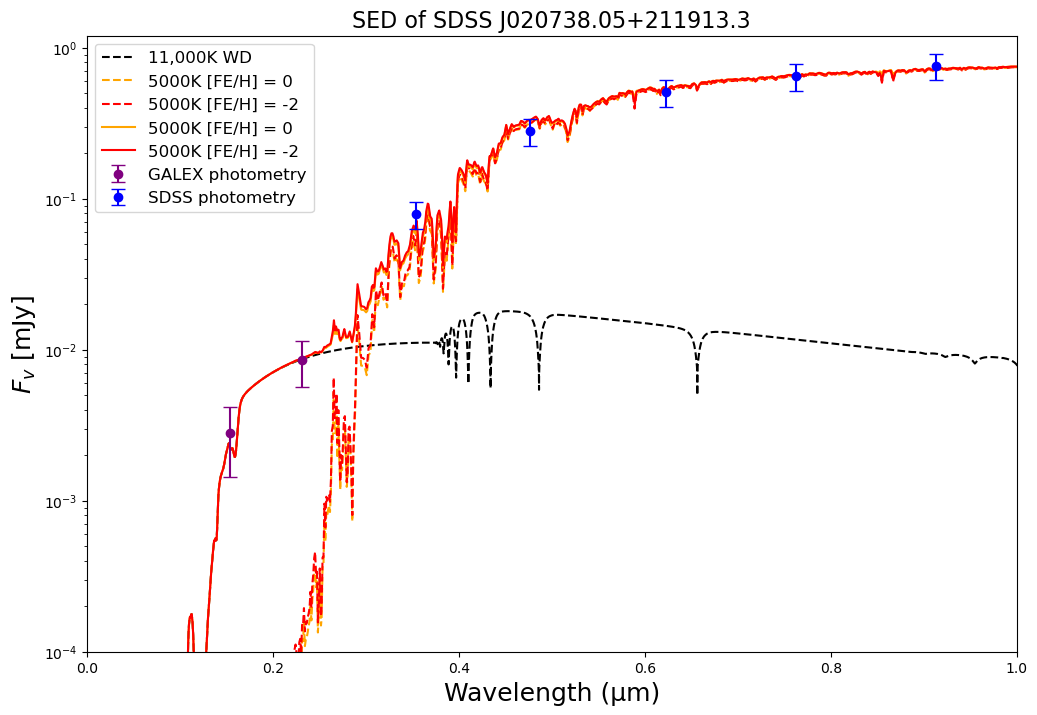

In [61]:

plt.figure(figsize=(12, 8))

plt.plot(
    wd_wavelength_um, wd_scaled,
    color='black', linewidth=1.5, linestyle='dashed',
    label='11,000K WD'
)

plt.plot(
    feh0_wavelength_um, feh0_scaled,
    color='orange', linewidth=1.5, linestyle='dashed',
    label='5000K [FE/H] = 0'
)

plt.plot(
    feh2_wavelength_um, feh2_scaled,
    color='red', linewidth=1.5, linestyle='dashed',
    label='5000K [FE/H] = -2'
)

plt.plot(
    wd_wavelength_um, combined_feh0_flux,
    color='orange', linewidth=1.5, linestyle='solid',
    label='5000K [FE/H] = 0'
)

plt.plot(
    wd_wavelength_um, combined_feh2_flux,
    color='red', linewidth=1.5, linestyle='solid',
    label='5000K [FE/H] = -2'
)


plt.errorbar(
    wavelength_um_galex,
    observed_fluxes_galex,
    yerr=observed_fluxes_galex_e,
    fmt='o', color='purple',
    capsize=5, elinewidth=1.5, zorder=10,
    label='GALEX photometry'
)

plt.errorbar(
    wavelength_um_sdss_full,
    observed_fluxes_sdss,
    yerr=observed_fluxes_sdss_e,
    fmt='o', color='blue',
    capsize=5, elinewidth=1.5, zorder=10,
    label='SDSS photometry'
)

plt.yscale('log')
plt.xlim(0, 1.0)
plt.ylim(1e-4, 1.2)
plt.xlabel('Wavelength (µm)', fontsize=18)
plt.ylabel('${F_v}$ [mJy]', fontsize=18)
plt.title('SED of SDSS J020738.05+211913.3', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# J0733

In [62]:
system_4 = merged_df[(merged_df["RA_degrees"] == 113.42195833333332) & (merged_df["Dec_degrees"] == 22.46636111111111)]


fd_fuv4 = flux_density_mjy(system_4["FUVmag"].iloc[0])  
fd_nuv4 = flux_density_mjy(system_4["NUVmag"].iloc[0])
fd_u4 = flux_density_mjy(system_4["upmag"].iloc[0])
fd_g4 = flux_density_mjy(system_4["gpmag"].iloc[0])
fd_r4 = flux_density_mjy(system_4["rpmag"].iloc[0])
fd_i4 = flux_density_mjy(system_4["ipmag"].iloc[0])
fd_z4 = flux_density_mjy(system_4["zpmag"].iloc[0])

e_fuv4 = error_prop_galex(system_4["FUVmag"].iloc[0], system_4["e_FUVmag"].iloc[0])
e_nuv4 = error_prop_galex(system_4["NUVmag"].iloc[0], system_4["e_NUVmag"].iloc[0])

e_upmag4 = error_prop_sdss(system_4["upmag"].iloc[0], system_4["e_upmag"].iloc[0])
e_gpmag4 = error_prop_sdss(system_4["gpmag"].iloc[0], system_4["e_gpmag"].iloc[0])
e_rpmag4 = error_prop_sdss(system_4["rpmag"].iloc[0], system_4["e_rpmag"].iloc[0])
e_ipmag4 = error_prop_sdss(system_4["ipmag"].iloc[0], system_4["e_ipmag"].iloc[0])
e_zpmag4 = error_prop_sdss(system_4["zpmag"].iloc[0], system_4["e_zpmag"].iloc[0])

observed_fluxes = np.array([fd_u4, fd_g4, fd_r4, fd_i4, fd_z4])
observed_fluxes_err = np.array([e_upmag4, e_gpmag4 , e_rpmag4, e_ipmag4, e_zpmag4])
observed_fluxes_err_filtered = np.array([e_gpmag4 , e_rpmag4, e_ipmag4, e_zpmag4])
observed_fluxes_filtered = np.array([fd_g4, fd_r4, fd_i4, fd_z4])
observed_galex = np.array([fd_fuv4, fd_nuv4])
observed_galex_err = np.array([e_fuv4, e_nuv4])

In [63]:
composite_results_2 = []

for wd_model in wd_models:
    wd_label = "WD"
    if wd_model['temperature']:
        wd_label += f", {wd_model['temperature']}"
    wd_data = pd.read_csv(wd_model["file"], delim_whitespace=True, header=None, 
                          names=['Wavelength_um', 'F_nu_mJy'])
    wd_wavelength_A = wd_data['Wavelength_um'].values * 1e4  
    wd_flux = wd_data['F_nu_mJy'].values         
    
    n_ms = len(ms_models)
    for i in range(n_ms):
        ms1_model = ms_models[i]
        ms1_label = "MS1"
        if ms1_model['metallicity']:
            ms1_label += f", {ms1_model['metallicity']}"
        if ms1_model['temperature']:
            ms1_label += f", {ms1_model['temperature']}"
        ms1_wave, ms1_flux = load_synthetic_model(ms1_model["file"])
        initial_params = [5.4e1, 3.3e-14] 
        result = minimize(chi2_comb, initial_params,
                  args=(wd_wavelength_A, wd_flux, ms1_wave, ms1_flux,
                        fuv_data, nuv_data, u_data, g_data, r_data, i_data, z_data,
                        observed_fluxes_filtered, observed_fluxes_err_filtered, observed_galex, err_galex),
                  method='Nelder-Mead')

        composite_results_2.append({
            "wd_label": wd_label,
            "ms1_label": ms1_label,
            "wd_temperature": wd_model["temperature"],
            "ms1_metallicity": ms1_model["metallicity"],
            "ms1_temperature": ms1_model["temperature"],
            "scale_wd": result.x[0],
            "scale_ms1": result.x[1],
            "chi2": result.fun
        })


Processing WD model: WD, 7000K
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 4000K 
 scale_wd = 1.923e+03, scale_ms1 = 6.573e-15, chi² = 2.622
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 4250K 
 scale_wd = 1.791e+03, scale_ms1 = 5.343e-15, chi² = 2.301
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 4500K 
 scale_wd = 1.668e+03, scale_ms1 = 4.189e-15, chi² = 2.390
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 4750K 
 scale_wd = 1.559e+03, scale_ms1 = 3.293e-15, chi² = 2.825
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 5000K 
 scale_wd = 1.481e+03, scale_ms1 = 2.605e-15, chi² = 3.521
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 5250K 
 scale_wd = 1.431e+03, scale_ms1 = 2.077e-15, chi² = 4.360
 WD: WD, 7000K + MS1: MS1, [Fe/H] = 0, 5500K 
 scale_wd = 1.400e+03, scale_ms1 = 1.675e-15, chi² = 5.269
 WD: WD, 7000K + MS1: MS1, [Fe/H] = -1, 4000K 
 scale_wd = 1.903e+03, scale_ms1 = 6.863e-15, chi² = 2.500
 WD: WD, 7000K + MS1: MS1, [Fe/H] = -1, 4250K 
 scale_wd = 1.784e+03, scale_ms1 = 5.343e-15, chi² = 2.301
 WD: WD, 7000K + MS1:

 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 4000K 
 scale_wd = 2.240e+02, scale_ms1 = 1.057e-14, chi² = 4.512
 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 4250K 
 scale_wd = 2.107e+02, scale_ms1 = 8.009e-15, chi² = 2.707
 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 4500K 
 scale_wd = 1.967e+02, scale_ms1 = 6.128e-15, chi² = 1.517
 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 4750K 
 scale_wd = 1.842e+02, scale_ms1 = 4.702e-15, chi² = 1.216
 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 5000K 
 scale_wd = 1.738e+02, scale_ms1 = 3.661e-15, chi² = 1.646
 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 5250K 
 scale_wd = 1.647e+02, scale_ms1 = 2.903e-15, chi² = 2.510
 WD: WD, 10000K + MS1: MS1, [Fe/H] = -2, 5500K 
 scale_wd = 1.555e+02, scale_ms1 = 2.347e-15, chi² = 3.618

Processing WD model: WD, 11000K
 WD: WD, 11000K + MS1: MS1, [Fe/H] = 0, 4000K 
 scale_wd = 1.382e+02, scale_ms1 = 1.069e-14, chi² = 4.980
 WD: WD, 11000K + MS1: MS1, [Fe/H] = 0, 4250K 
 scale_wd = 1.307e+02, scale_ms1 = 8.368e-15, chi² = 2.399
 WD: W

 WD: WD, 14000K + MS1: MS1, [Fe/H] = 0, 5500K 
 scale_wd = 2.531e+01, scale_ms1 = 2.587e-15, chi² = 3.008
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 4000K 
 scale_wd = 3.044e+01, scale_ms1 = 1.211e-14, chi² = 9.826
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 4250K 
 scale_wd = 2.953e+01, scale_ms1 = 9.109e-15, chi² = 6.500
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 4250K 
 scale_wd = 2.855e+01, scale_ms1 = 6.914e-15, chi² = 3.886
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 4750K 
 scale_wd = 2.763e+01, scale_ms1 = 5.276e-15, chi² = 2.444
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 5000K 
 scale_wd = 2.679e+01, scale_ms1 = 4.091e-15, chi² = 2.069
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 5250K 
 scale_wd = 2.598e+01, scale_ms1 = 3.230e-15, chi² = 2.369
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -1, 5500K 
 scale_wd = 2.511e+01, scale_ms1 = 2.599e-15, chi² = 3.047
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -2, 4000K 
 scale_wd = 3.041e+01, scale_ms1 = 1.203e-14, chi² = 9.650
 WD: WD, 14000K + MS1: MS1, [Fe/H] = -

 WD: WD, 17000K + MS1: MS1, [Fe/H] = -2, 5250K 
 scale_wd = 1.117e+01, scale_ms1 = 3.298e-15, chi² = 2.970
 WD: WD, 17000K + MS1: MS1, [Fe/H] = -2, 5500K 
 scale_wd = 1.082e+01, scale_ms1 = 2.655e-15, chi² = 3.501


In [68]:
# Sort the composite results by chi2 value (lowest first)
best_results_2 = sorted(composite_results_2, key=lambda x: x["chi2"])
best_2 = best_results_2[0]
print("\nBest Optimal Model:")
print(f"WD Model: {best_2['wd_label']} (Temperature: {best_2['wd_temperature']})")
print(f"MS1 Model: {best_2['ms1_label']} (Metallicity: {best_2['ms1_metallicity']}, Temperature: {best_2['ms1_temperature']})")
print(f"Scale factors -> WD: {best_2['scale_wd']:.3e}, MS1: {best_2['scale_ms1']:.3e}")
print(f"Chi²: {best_2['chi2']:.3f}")

ms1_metallicity = best_2['ms1_metallicity']
wd_sf = best_2['scale_wd']
ms_sf = best_2['scale_ms1']
ms1_temperature = best_2['ms1_temperature']


Best Optimal Model:
WD Model: WD, 11000K (Temperature: 11000K)
MS1 Model: MS1, [Fe/H] = -1, 4750K (Metallicity: [Fe/H] = -1, Temperature: 4750K)
Scale factors -> WD: 1.164e+02, MS1: 4.856e-15
Chi²: 0.214


In [69]:
filtered_models = []
for result in composite_results_2:
    if (result["ms1_temperature"] == ms1_temperature and
        result["ms1_metallicity"] != ms1_metallicity and
        result["wd_label"] == wd_temp):
        filtered_models.append(result)


best_model = filtered_models[0]
print("\nFiltered best model alternative:")
print(f"Optimal WD model: {best_model['wd_label']}")
print(f"Optimal MS model: {best_model['ms1_label']}")
print(f"Scale factors WD: {best_model['scale_wd']:.3e}, MS1: {best_model['scale_ms1']:.3e}")
print(f"Chi²: {best_model['chi2']:.3f}")
scale_ms2 = best_model['scale_ms1']



Filtered best model alternative:
Optimal WD model: WD, 11000K
Optimal MS model: MS1, [Fe/H] = 0, 4750K
Scale factors WD: 1.170e+02, MS1: 4.845e-15
Chi²: 0.225


In [73]:

wd_model_path = '/Users/amberbarlow/Downloads/da11000_800.dat'
wd_data = pd.read_csv(wd_model_path, delim_whitespace=True, header=None, names=['Wavelength_um', 'F_nu_mJy'])
wd_wavelength_A = wd_data['Wavelength_um'] * 1e4
wd_wavelength_um = wd_data['Wavelength_um']
wd_flux = wd_data['F_nu_mJy'] 

feh01_file = '/Users/amberbarlow/Downloads/km01_4750.fits'
feh01_wavelength_um, feh01_flux_mjy = load_synthetic_model(feh01_file)

feh2_file = '/Users/amberbarlow/Downloads/km02_4750.fits'
feh2_wavelength_um, feh2_flux_mjy = load_synthetic_model(feh2_file)

ms_scaled = feh01_flux_mjy*ms_sf
ms2_scaled = feh2_flux_mjy*scale_ms2
wd_scaled = wd_flux*wd_sf

In [74]:

# Interpolate metallicity models to match WD wavelength grid
feh1_interp = interp1d(feh01_wavelength_um, ms_scaled, kind='linear', fill_value="extrapolate")
feh2_interp = interp1d(feh2_wavelength_um, ms2_scaled, kind='linear', fill_value="extrapolate")

# Interpolated fluxes
feh1_flux_interpolated = feh1_interp(wd_wavelength_um)
feh2_flux_interpolated = feh2_interp(wd_wavelength_um)

# Combine fluxes directly with WD spectrum
combined_feh1_flux = feh1_flux_interpolated + wd_scaled
combined_feh2_flux = feh2_flux_interpolated + wd_scaled

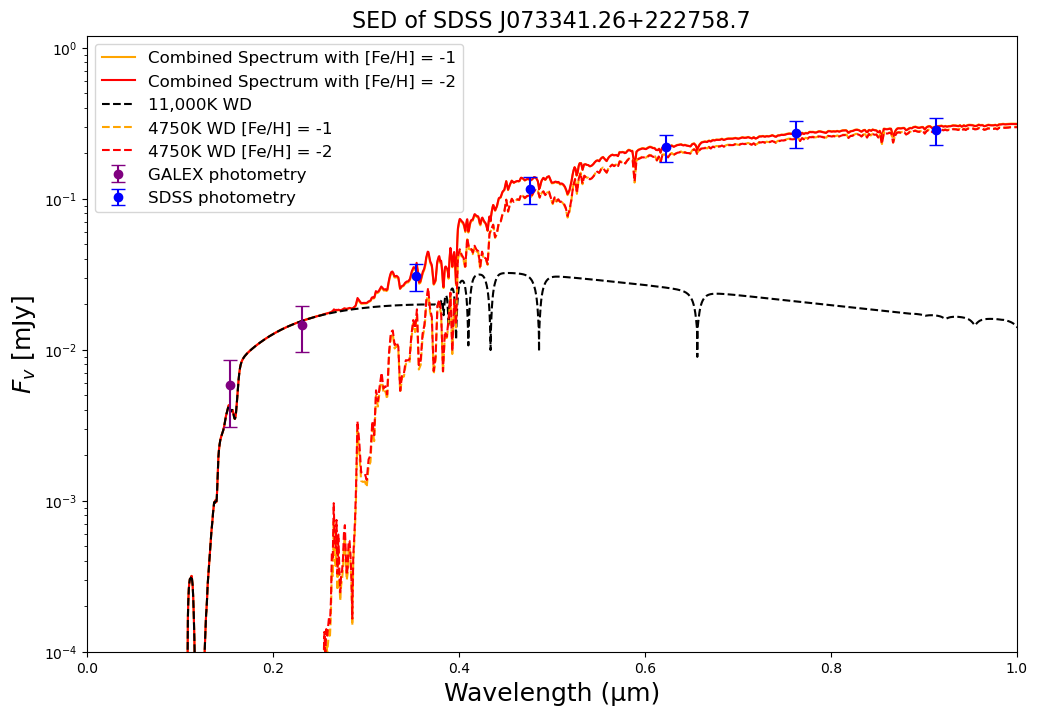

In [76]:

plt.figure(figsize=(12, 8))

plt.plot(
    wd_wavelength_um, combined_feh1_flux,
    color='orange', linewidth=1.5,
    label='Combined Spectrum with [Fe/H] = -1'
)

plt.plot(
    wd_wavelength_um, combined_feh2_flux,
    color='red', linewidth=1.5,
    label='Combined Spectrum with [Fe/H] = -2'
)

plt.plot(
    wd_wavelength_um, wd_scaled,
    color='black', linewidth=1.5, linestyle='dashed',
    label='11,000K WD'
)

plt.plot(
    feh01_wavelength_um, ms_scaled,
    color='orange', linewidth=1.5, linestyle='dashed',
    label='4750K WD [Fe/H] = -1'
)

plt.plot(
    feh2_wavelength_um, ms2_scaled,
    color='red', linewidth=1.5, linestyle='dashed',
    label='4750K WD [Fe/H] = -2'
)

plt.errorbar(
    wavelength_um_galex,
    observed_galex,
    yerr=observed_galex_err,
    fmt='o', color='purple',
    capsize=5, elinewidth=1.5, zorder=10,
    label='GALEX photometry'
)

plt.errorbar(
    wavelength_um_sdss_full,
    observed_fluxes,
    yerr=observed_fluxes_err,
    fmt='o', color='blue',
    capsize=5, elinewidth=1.5, zorder=10,
    label='SDSS photometry'
)
plt.yscale('log')
plt.xlim(0, 1.0)
plt.ylim(1e-4, 1.2)
plt.xlabel('Wavelength (µm)', fontsize=18)
plt.ylabel('${F_v}$ [mJy]', fontsize=18)
plt.title('SED of SDSS J073341.26+222758.7', fontsize=16)
plt.legend(fontsize=12)
plt.show()

# J0123

In [93]:

merged_df = pd.merge(sdss_df, galex_df, on=['RA_degrees', 'Dec_degrees'], how='inner')
system = merged_df[(merged_df["RA_degrees"] == 205.94254166666667) &
                   (merged_df["Dec_degrees"] == 46.57344444444445)]


fd_fuv = flux_density_mjy(system["FUVmag"].iloc[0])
fd_nuv = flux_density_mjy(system["NUVmag"].iloc[0])

fd_u   = flux_density_mjy(system["upmag"].iloc[0])
fd_g   = flux_density_mjy(system["gpmag"].iloc[0])
fd_r   = flux_density_mjy(system["rpmag"].iloc[0])
fd_i   = flux_density_mjy(system["ipmag"].iloc[0])
fd_z   = flux_density_mjy(system["zpmag"].iloc[0])


e_fuv   = error_prop_galex(system["FUVmag"].iloc[0], system["e_FUVmag"].iloc[0])
e_nuv   = error_prop_galex(system["NUVmag"].iloc[0], system["e_NUVmag"].iloc[0])
e_upmag = error_prop_sdss(system["upmag"].iloc[0], system["e_upmag"].iloc[0])
e_gpmag = error_prop_sdss(system["gpmag"].iloc[0], system["e_gpmag"].iloc[0])
e_rpmag = error_prop_sdss(system["rpmag"].iloc[0], system["e_rpmag"].iloc[0])
e_ipmag = error_prop_sdss(system["ipmag"].iloc[0], system["e_ipmag"].iloc[0])
e_zpmag = error_prop_sdss(system["zpmag"].iloc[0], system["e_zpmag"].iloc[0])


observed_fluxes = np.array([fd_u, fd_g, fd_r, fd_i, fd_z])
observed_fluxes_filtered = np.array([fd_g, fd_r, fd_i, fd_z])
observed_galex = np.array([fd_fuv, fd_nuv])
observed_galex_e = np.array([e_fuv, e_nuv])
observed_fluxes_e_filt = np.array([e_gpmag, e_rpmag, e_ipmag, e_zpmag])
observed_fluxes_e = np.array([e_upmag, e_gpmag, e_rpmag, e_ipmag, e_zpmag])
observed_fluxes_filt = np.array([fd_g, fd_r, fd_i, fd_z])

In [94]:

composite_results_2 = []

for wd_model in wd_models:
    wd_label = "WD"
    if wd_model.get('temperature'):
        wd_label += f", {wd_model['temperature']}"
    wd_data = pd.read_csv(wd_model["file"], delim_whitespace=True, header=None, 
                          names=['Wavelength_um', 'F_nu_mJy'])
    wd_wavelength_A = wd_data['Wavelength_um'].values * 1e4  
    wd_flux = wd_data['F_nu_mJy'].values         

    # Loop over each MS model
    for ms1_model in ms_models:
        ms1_label = "MS1"
        if ms1_model.get('metallicity'):
            ms1_label += f", {ms1_model['metallicity']}"
        if ms1_model.get('temperature'):
            ms1_label += f", {ms1_model['temperature']}"
            
        ms1_wave, ms1_flux = load_synthetic_model(ms1_model["file"])
        initial_params = [5.4e1, 3.3e-14]
        
        result = minimize(chi2_comb, initial_params,
                          args=(wd_wavelength_A, wd_flux, ms1_wave, ms1_flux,
                                fuv_data, nuv_data, u_data, g_data, r_data, i_data, z_data,
                                observed_fluxes_filtered, observed_fluxes_e_filt, observed_galex, observed_galex_e),
                          method='Nelder-Mead')

        composite_results_2.append({
            "wd_label": wd_label,
            "ms1_label": ms1_label,
            "wd_temperature": wd_model.get("temperature"),
            "ms1_metallicity": ms1_model.get("metallicity"),
            "ms1_temperature": ms1_model.get("temperature"),
            "scale_wd": result.x[0],
            "scale_ms1": result.x[1],
            "chi2": result.fun
        })


In [95]:

best_results_2 = sorted(composite_results_2, key=lambda x: x["chi2"])
best_2 = best_results_2[0]
print("\nBest Optimal Model:")
print(f"WD Model: {best_2['wd_label']} (Temperature: {best_2['wd_temperature']})")
print(f"MS1 Model: {best_2['ms1_label']} (Metallicity: {best_2['ms1_metallicity']}, Temperature: {best_2['ms1_temperature']})")
print(f"Scale factors -> WD: {best_2['scale_wd']:.3e}, MS1: {best_2['scale_ms1']:.3e}")
print(f"Chi²: {best_2['chi2']:.3f}")

wd_sf = best_2['scale_wd']
wd_temp = best_2['wd_temperature']
ms_sf = best_2['scale_ms1']
ms1_metallicity = best_2['ms1_metallicity']
ms1_temperature = best_2['ms1_temperature']


Best Optimal Model:
WD Model: WD, 13000K (Temperature: 13000K)
MS1 Model: MS1, [Fe/H] = -2, 4000K (Metallicity: [Fe/H] = -2, Temperature: 4000K)
Scale factors -> WD: 4.239e+01, MS1: 1.823e-14
Chi²: 0.498


In [96]:

wd_model = '/Users/amberbarlow/Downloads/da13000_800.dat'
wd_data = pd.read_csv(wd_model, delim_whitespace=True, header=None, names=['Wavelength_um', 'F_nu_mJy'])
wd_wavelength_A = wd_data['Wavelength_um'] * 1e4
wd_wavelength_um = wd_data['Wavelength_um']
wd_flux_mjy = wd_data['F_nu_mJy']
wd_scaled = wd_flux_mjy*wd_sf

feh0_file = '/Users/amberbarlow/Downloads/km02_4000.fits'
feh0_wavelength_um, feh0_flux_mjy = load_synthetic_model(feh0_file)

feh2_file = '/Users/amberbarlow/Downloads/km02_4000.fits'
feh2_wavelength_um, feh2_flux_mjy = load_synthetic_model(feh2_file)

ms_scaled = feh0_flux_mjy*ms_sf
wd_scaled = wd_sf*wd_flux_mjy
ms2_scaled = feh2_flux_mjy*1.5e-14

In [97]:

# Interpolate metallicity models to match WD wavelength grid
feh1_interp = interp1d(feh0_wavelength_um, ms_scaled, kind='linear', fill_value="extrapolate")
feh2_interp = interp1d(feh2_wavelength_um, ms2_scaled, kind='linear', fill_value="extrapolate")

# Interpolated fluxes
feh1_flux_interpolated = feh1_interp(wd_wavelength_um)
feh2_flux_interpolated = feh2_interp(wd_wavelength_um)

# Combine fluxes directly with WD spectrum
combined_feh1_flux = feh1_flux_interpolated + wd_scaled
combined_feh2_flux = feh2_flux_interpolated + wd_scaled

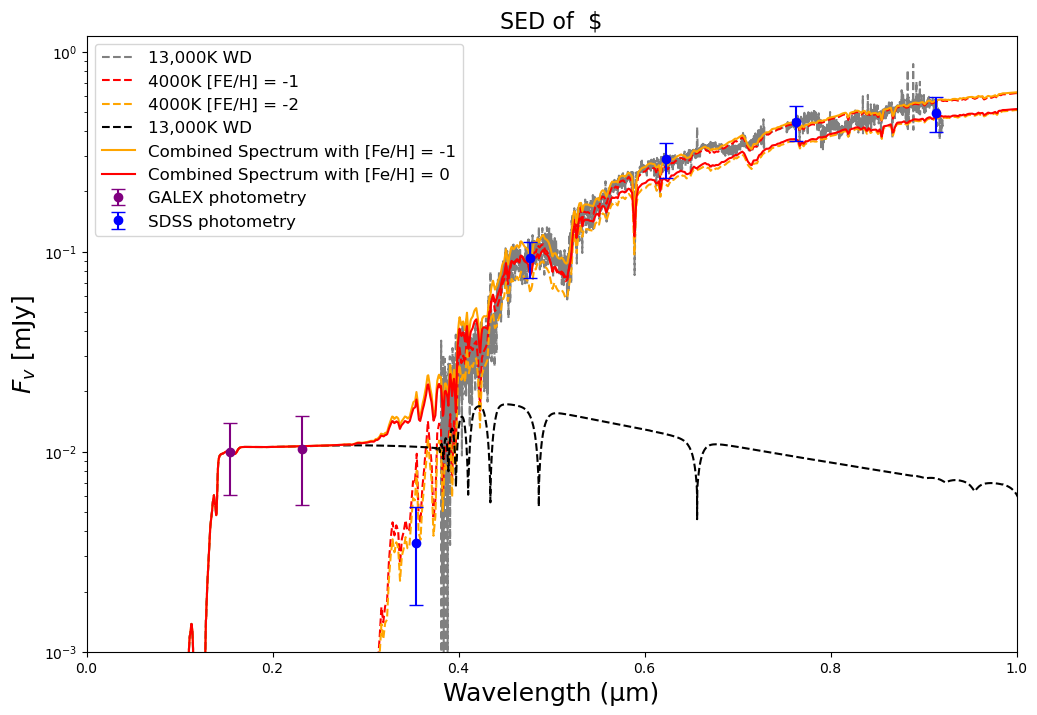

In [98]:


plt.figure(figsize=(12, 8))

plt.plot(
    wave_um_spec, spec_flux_mjy*5.5e-1,
    color='grey', linewidth=1.5, linestyle='dashed',
    label='13,000K WD'
)

plt.plot(
    feh0_wavelength_um, ms_scaled,
    color='red', linewidth=1.5, linestyle='dashed',
    label='4000K [FE/H] = -1 '
)

plt.plot(
    feh2_wavelength_um, ms2_scaled,
    color='orange', linewidth=1.5, linestyle='dashed',
    label='4000K [FE/H] = -2 '
)


plt.plot(
    wd_wavelength_um, wd_scaled,
    color='black', linewidth=1.5, linestyle='dashed',
    label='13,000K WD'
)


plt.errorbar(
    wavelength_um_galex,
    observed_galex,
    yerr=err_galex,
    fmt='o', color='purple',
    capsize=5, elinewidth=1.5, zorder=10,
    label='GALEX photometry'
)

plt.errorbar(
    wavelength_um_sdss_full,
    observed_fluxes,
    yerr=observed_fluxes_e,
    fmt='o', color='blue',
    capsize=5, elinewidth=1.5, zorder=10,
    label='SDSS photometry'
)

plt.plot(
    wd_wavelength_um, combined_feh1_flux,
    color='orange', linewidth=1.5,
    label='Combined Spectrum with [Fe/H] = -1'
)

plt.plot(
    wd_wavelength_um, combined_feh2_flux,
    color='red', linewidth=1.5,
    label='Combined Spectrum with [Fe/H] = 0'
)

plt.yscale('log')
plt.xlim(0, 1.0)
plt.ylim(1e-3, 1.2)
plt.xlabel('Wavelength (µm)', fontsize=18)
plt.ylabel('${F_v}$ [mJy]', fontsize=18)
plt.title('SED of  $', fontsize=16)
plt.legend(fontsize=12)
plt.show()